In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import plotly.graph_objects as go
import json

In [2]:
from src.datasets.datamodules import DataModule
from src.my_model.transformer import *

In [3]:
# Instantiate the DataModule num_workers=16)
# dataset_wrapper = DataModule(dataset_type="tml", dataset_dir="Data/Tml/trackml_100_events_splits") # 20 000 particles
dataset_wrapper = DataModule(dataset_type="tml", dataset_dir="Data/Tml/train_1") # 1 404 273 particles

dataset_wrapper.setup(stage="test")
tl = dataset_wrapper.test_dataloader()
# 1 min 41.4 s

─────────────────────────────────────────────────── Tml Dataset ───────────────────────────────────────────────────

Loading data from Data/Tml/train_1/preprocessed_test.pt

/home/couthures/Bureau/TrackParameters/TrackFormer/src/datasets/datamodules.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.datalist = torch.load(self.data_file)


In [4]:
def get_model_checkpoint_path(version_dir: str):
    version_dir = Path(version_dir)
    checkpoint_dir = version_dir / "checkpoints"
    checkpoint_files = list(checkpoint_dir.glob("*.ckpt"))
    assert len(checkpoint_files) == 1, f"Found {len(checkpoint_files)} checkpoints in {checkpoint_dir}"
    return checkpoint_files[0]

In [5]:
# Load models
mse_trans_tml = get_model_checkpoint_path("Data/TrackML/version_115")
qloss_tml_trasf = get_model_checkpoint_path("Data/TrackML/version_114")

 
# _instantiator is a function that is called to instantiate the model
# Here the models have been trained using cli raising an error if _instantiator is not None
transf_mse_model = TrackFormer.load_from_checkpoint(checkpoint_path=mse_trans_tml, _instantiator=None)
transf_mse_model.eval().to("cpu")

qloss_transf_tt_model = TrackFormer.load_from_checkpoint(checkpoint_path=qloss_tml_trasf, _instantiator=None)
_ = qloss_transf_tt_model.eval().to("cpu")

In [6]:
target_labels = ["p_t", "p_z"]

In [7]:
p_pred_mse_list = []
p_pred_qloss_list = []
p_true_list = []

bad_tracks_q = []
bad_tracks_mse = []


with torch.no_grad():
    for i, (input, mask, target) in enumerate(tqdm(tl)):
        
        # Transformers
        p_pred_mse = transf_mse_model(input)
        p_pred_qloss = qloss_transf_tt_model(input)
        p_true = target

        p_pred_mse_list.extend(p_pred_mse.tolist())
        p_pred_qloss_list.extend(p_pred_qloss.tolist())
        p_true_list.extend(p_true.tolist())

        error_mse = p_pred_mse - p_true
        error_qloss = p_pred_qloss - p_true

        relative_error_mse = error_mse / p_true
        relative_error_qloss = error_qloss / p_true

        abs_relative_error_mse = abs(relative_error_mse)
        abs_relative_error_qloss = abs(relative_error_qloss)

        # if (abs_relative_error_mse > 10).any():
        #     mask_ = abs_relative_error_mse > 10
        #     selected = input[mask_][0]
            
            
        #     error_values = error_mse[mask_].tolist()
        #     p_values = p_true[mask_].tolist()
        #     bad_tracks_mse.extend(((error, p), selected) for error, p in zip(error_values, p_values))

        # if (abs_relative_error_qloss > 10).any():
        #     mask_ = abs_relative_error_qloss > 10
        #     selected = input[mask_][0]
            
        #     error_values = error_qloss[mask_].tolist()
        #     p_values = p_true[mask_].tolist()
        #     bad_tracks_q.extend(((error, p), selected) for error, p in zip(error_values, p_values))



  0%|          | 0/43884 [00:00<?, ?it/s]

In [7]:
def view_trajectory(inputs, mask=None):
    """
    Plots the trajectory of a particle in 3D.
    """
    
    if mask is None:
            # Filter out zero rows
            inputs = inputs[(inputs != 0).any(dim=1)]

    else:
        inputs = inputs[mask]

    x = inputs[:, 0].numpy()
    y = inputs[:, 1].numpy()
    z = inputs[:, 2].numpy()

    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines+markers',
        marker=dict(size=4, color='blue', opacity=0.8),
        line=dict(color='blue', width=2)
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Particle Trajectory'
    )

    fig.show()


In [ ]:
i = 5
view_trajectory(bad_tracks_q[i][1])

In [ ]:
thing = bad_tracks_q[i][1][(bad_tracks_q[i][1] != 0).any(dim=1)][:,:2]

In [ ]:
plt.scatter(thing[:,0],thing[:,1])

In [ ]:
from src.my_model.benchmarks import CircleFit



cf = CircleFit()


# f"circle pred: {cf.fit(thing.unsqueeze(0)).item():.2f} \t true{}"
f"circle pred: {cf.fit(thing.unsqueeze(0)).item():.2f} \t true"

In [ ]:
bad_tracks_q[i][0][1]

In [8]:

def sync_plot_limits():
    # Use the same axis limits for both plots
    left, right = None, None
    bottom, top = None, None

    for i in range(1, 3):
        plt.subplot(1, 2, i)
        left_, right_ = plt.xlim()
        bottom_, top_ = plt.ylim()

        if left is None or left_ < left:
            left = left_
        if right is None or right_ > right:
            right = right_
        if bottom is None or bottom_ < bottom:
            bottom = bottom_
        if top is None or top_ > top:
            top = top_

    # Apply the same limits to the subplots
    for i in range(1, 3):
        plt.subplot(1, 2, i)
        plt.xlim(left, right)
        plt.ylim(bottom, top)

In [9]:
output_dir = Path("Results/TrackML/")

experiment_name = "xyz_n_hits_5_pt_pz"

output_dir = output_dir / experiment_name

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True, parents=True)

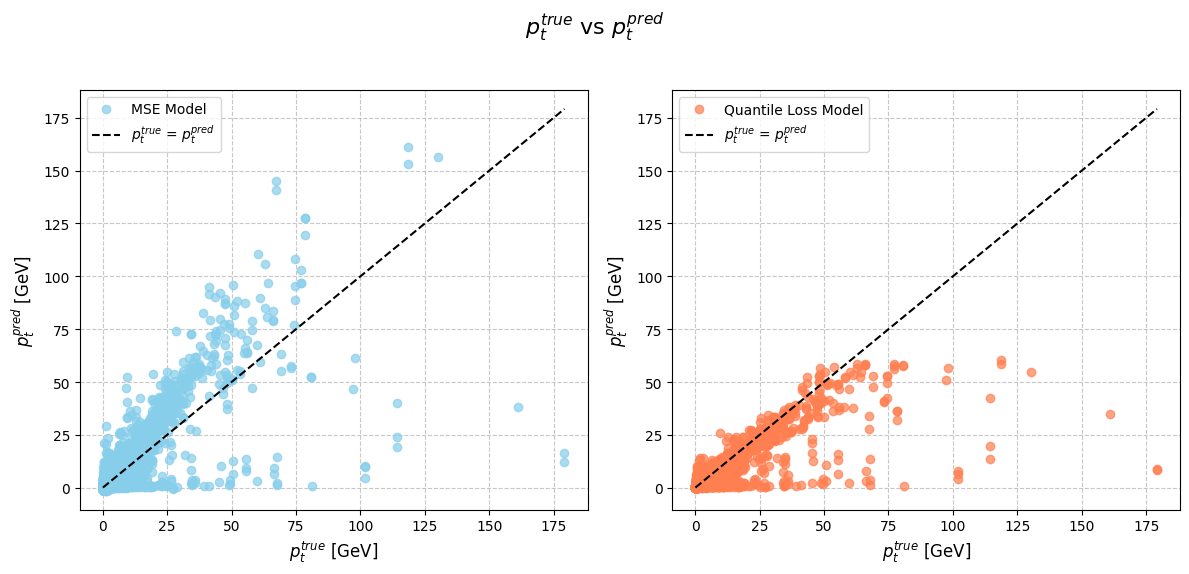

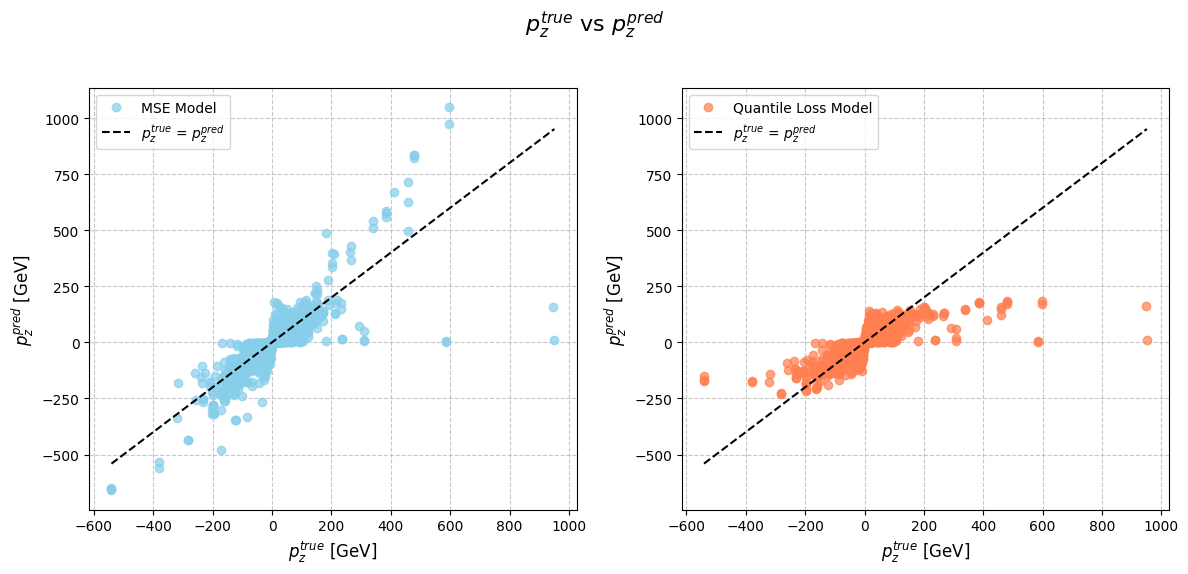

In [10]:
def plot_pi_true_vs_pred():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]
        
        title = f"${var}^{{true}}$ vs ${var}^{{pred}}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = pred_label + " [GeV]"
        filename = f"{var}_true_vs_{var}_pred_square.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        min_pi_true = min(pi_true_list)
        max_pi_true = max(pi_true_list)

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.plot(pi_true_list, pi_pred_mse_list, alpha=0.7, label='MSE Model', color='skyblue', marker='o', linestyle='None')
        # Add x = y line
        plt.plot([min_pi_true, max_pi_true], [min_pi_true, max_pi_true], color='black', linestyle='--', label=f'{true_label} = {pred_label}')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.plot(pi_true_list, pi_pred_qloss_list, alpha=0.7, label='Quantile Loss Model', color='coral', marker='o', linestyle='None')
        # Add x = y line
        plt.plot([min_pi_true, max_pi_true], [min_pi_true, max_pi_true], color='black', linestyle='--', label=f'{true_label} = {pred_label}')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()


        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_true_vs_pred()

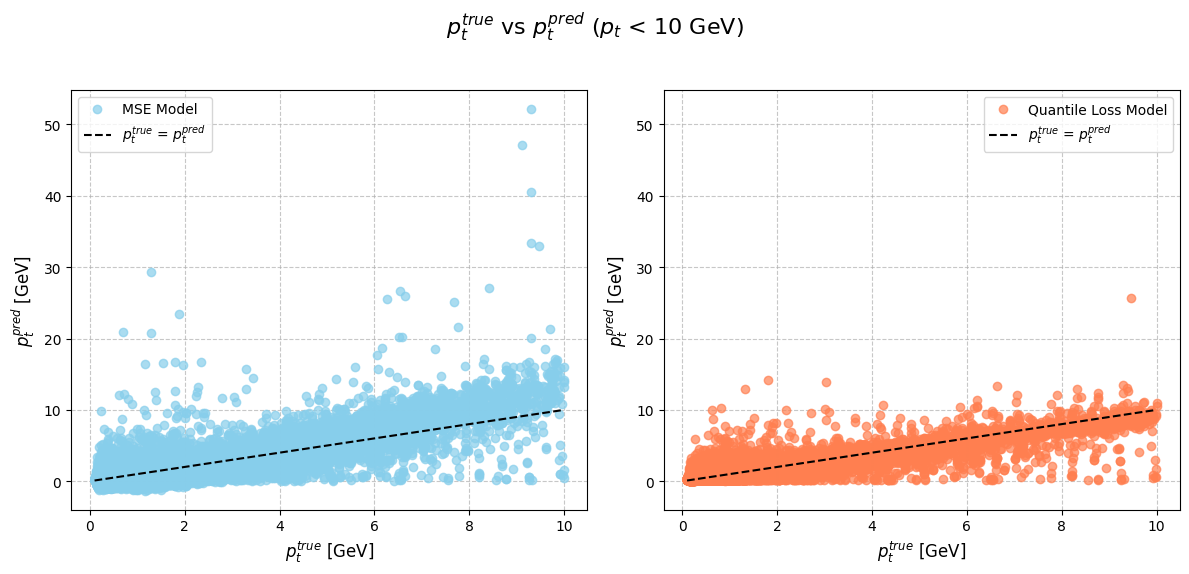

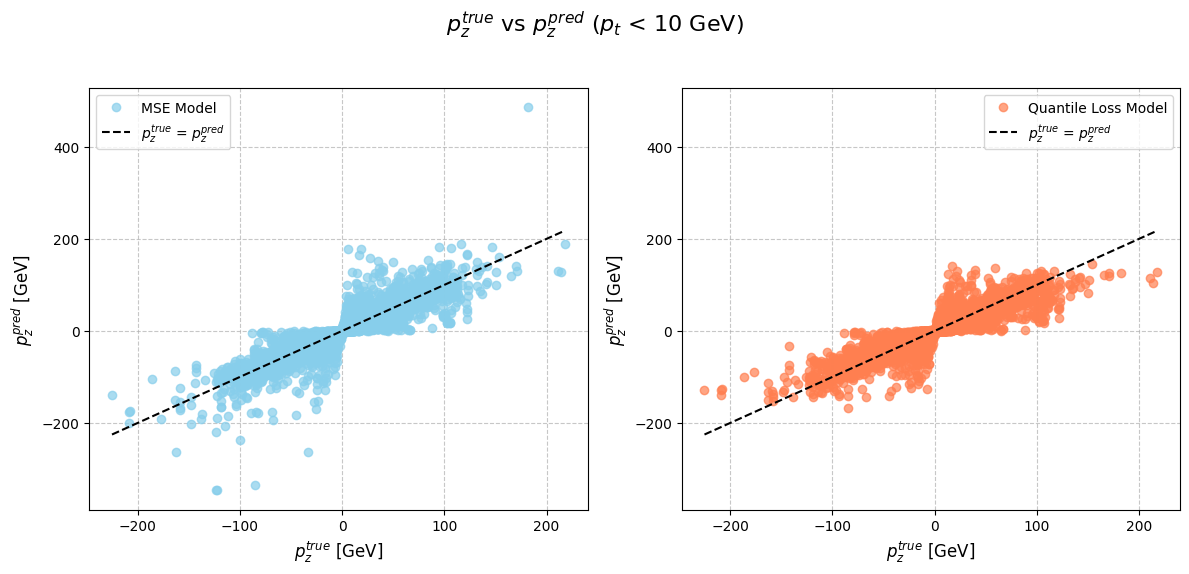

In [11]:
def plot_pi_true_vs_pred_low_pt():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]
        
        pt_true = np.array(p_true_list)[:, 0]
        mask = pt_true < 10
        pi_true_list = pi_true_list[mask]
        pi_pred_mse_list = pi_pred_mse_list[mask]
        pi_pred_qloss_list = pi_pred_qloss_list[mask]

        title = f"${var}^{{true}}$ vs ${var}^{{pred}}$ ($p_t$ < 10 GeV)"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = pred_label + " [GeV]"
        filename = f"{var}_true_vs_{var}_pred_square_low_pt.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        min_pi = min(min(pi_true_list), min(pi_pred_mse_list), min(pi_pred_qloss_list))
        min_pi = min(pi_true_list)
        max_pi = max(max(pi_true_list), max(pi_pred_mse_list), max(pi_pred_qloss_list))
        max_pi = max(pi_true_list)

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.plot(pi_true_list, pi_pred_mse_list, alpha=0.7, label='MSE Model', color='skyblue', marker='o', linestyle='None')
        # Add x = y line
        plt.plot([min_pi, max_pi], [min_pi, max_pi], color='black', linestyle='--', label=f'{true_label} = {pred_label}')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.plot(pi_true_list, pi_pred_qloss_list, alpha=0.7, label='Quantile Loss Model', color='coral', marker='o', linestyle='None')
        # Add x = y line
        plt.plot([min_pi, max_pi], [min_pi, max_pi], color='black', linestyle='--', label=f'{true_label} = {pred_label}')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()


        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_true_vs_pred_low_pt()

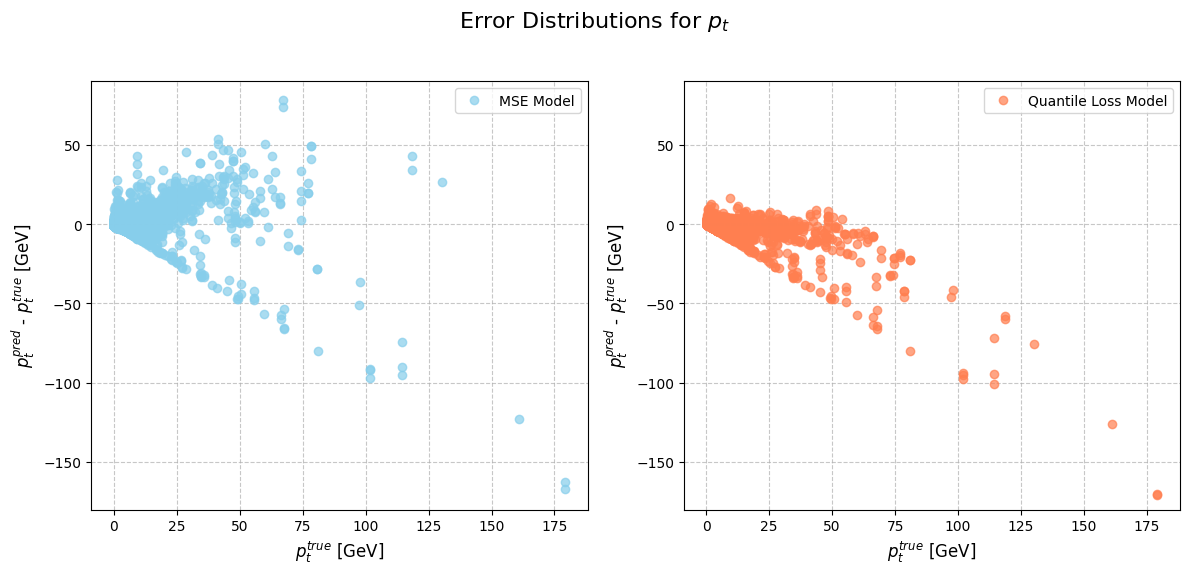

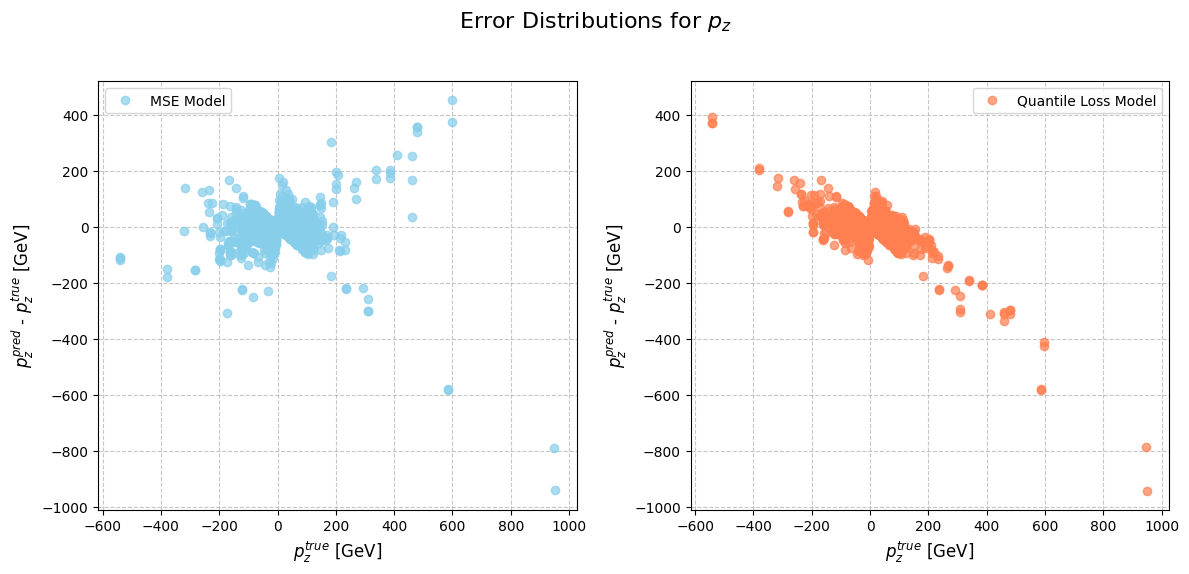

In [12]:
def plot_pi_error_distributions():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list
        
        title = f"Error Distributions for ${var}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = f"{pred_label} - {true_label}" + " [GeV]"
        filename = f"error_distributions_{var}.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.plot(pi_true_list, errors_mse_var, alpha=0.7, label='MSE Model', color='skyblue', marker='o', linestyle='None')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.plot(pi_true_list, errors_qloss_var, alpha=0.7, label='Quantile Loss Model', color='coral', marker='o', linestyle='None')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_error_distributions()

[ 0  1  2  4  6  8 12 16 20 24 28 34 40 50]


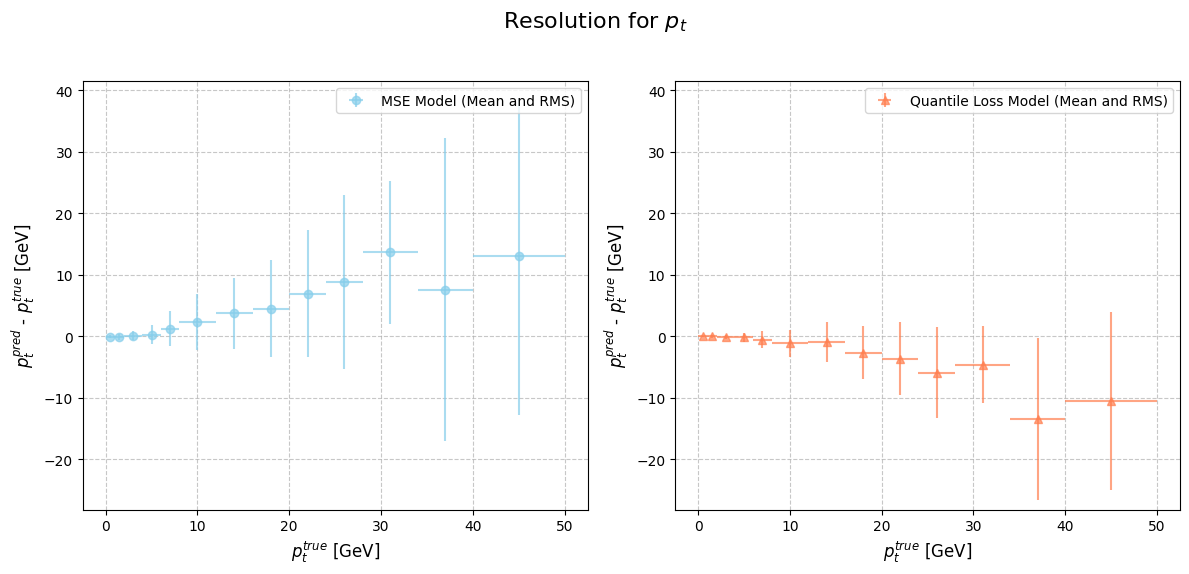

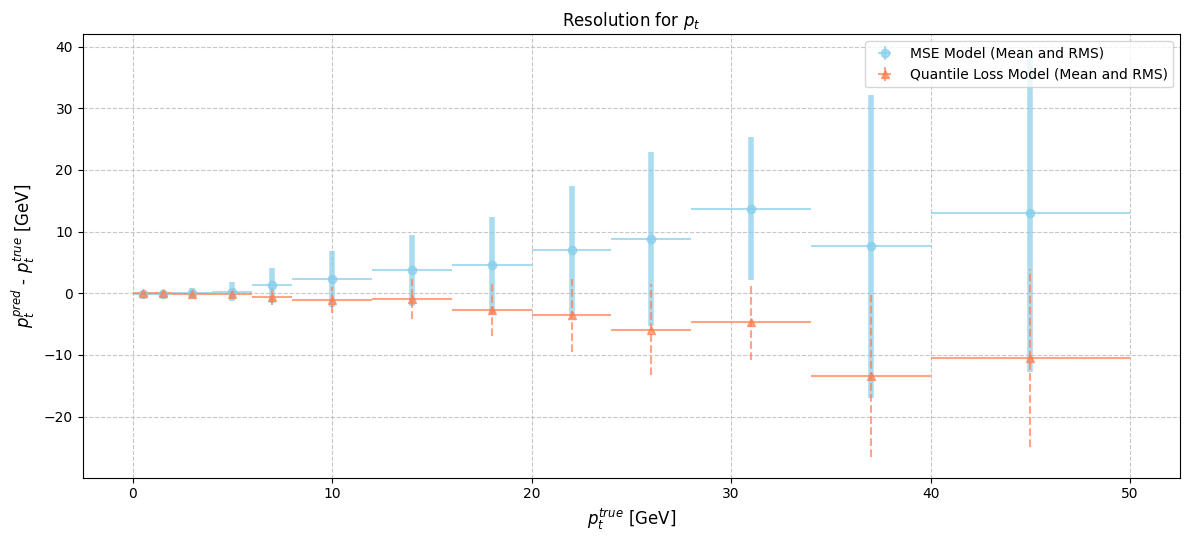

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


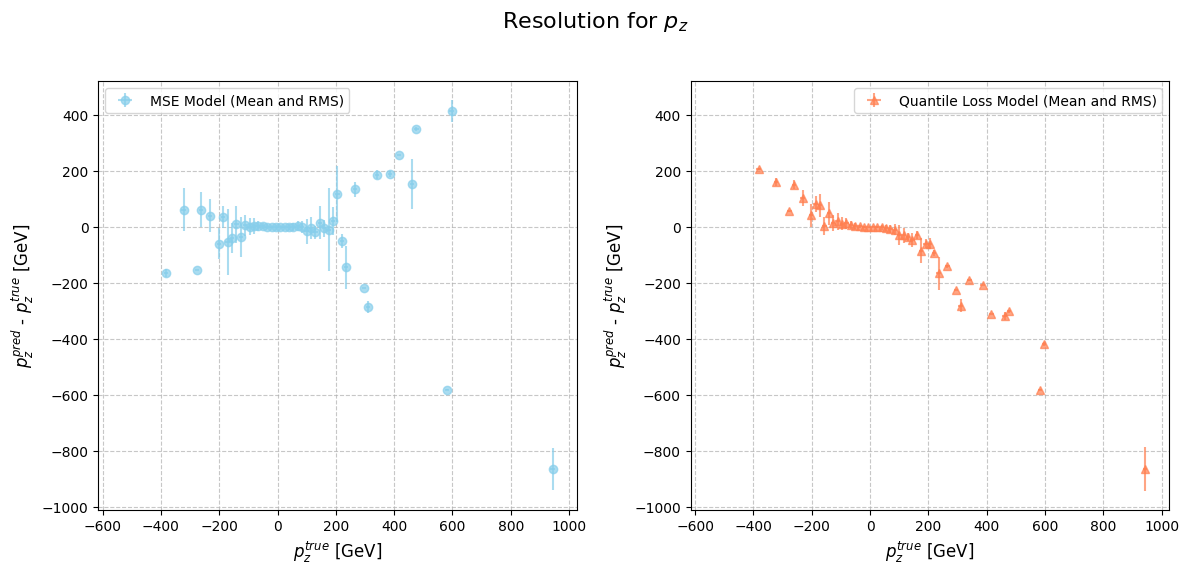

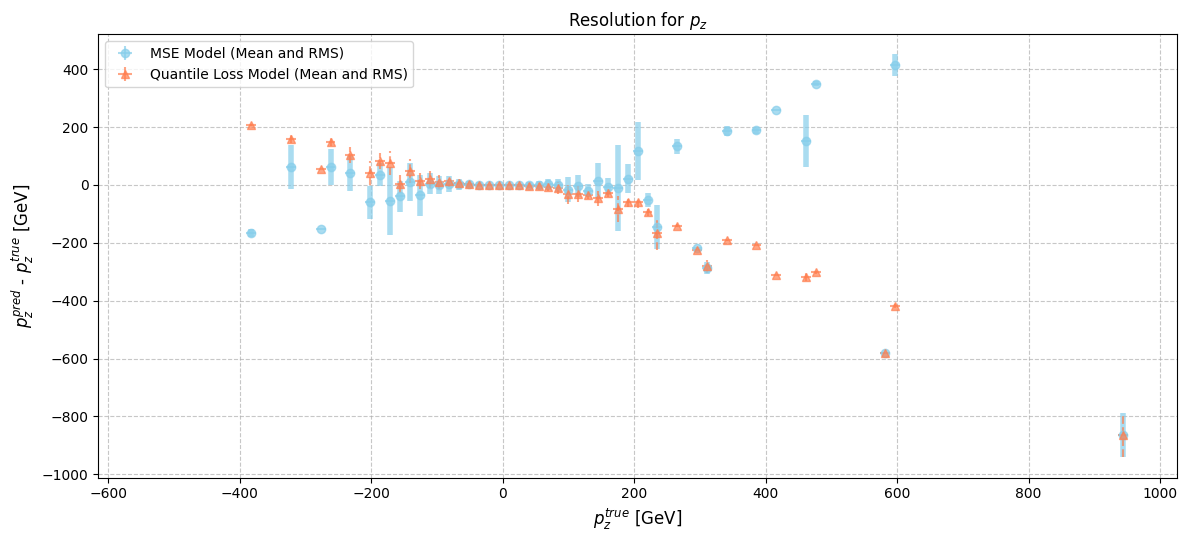

In [13]:
def plot_pi_resolutions():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        title = f"Resolution for ${var}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = f"{pred_label} - {true_label}" + " [GeV]"
        filename = f"resolution_{var}.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(min(pi_true_list), max(pi_true_list), 100)
        if var_index == 0:
            bins = np.logspace(
                np.log10(min(pi_true_list)), np.log10(max(pi_true_list)), 15
            )
            bins = np.logspace(
                np.log10(min(pi_true_list)), np.log10(50), 10
            )
            bins = np.array([0, 1, 2, 4, 6, 8, 12, 16, 20, 24, 28, 34, 40, 50])
            print(bins)

        bin_counts_mse = []
        bin_counts_q_loss = []
        bin_std_mse = []
        bin_std_q_loss = []

        for bin_index in range(len(bins)):
            if bin_index == 0:
                lower_bound = -np.inf
                continue
            else:
                lower_bound = bins[bin_index - 1]
            upper_bound = bins[bin_index]

            sel = (lower_bound < pi_true_list) & (pi_true_list <= upper_bound)
            bin_counts_mse.append(np.mean(errors_mse_var[sel]))
            bin_counts_q_loss.append(np.mean(errors_qloss_var[sel]))
            bin_std_mse.append(np.std(errors_mse_var[sel]))
            bin_std_q_loss.append(np.std(errors_qloss_var[sel]))

        bin_centers = (bins[1:] + bins[:-1]) / 2

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.errorbar(
            bin_centers,
            bin_counts_mse,
            yerr=bin_std_mse,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="MSE Model (Mean and RMS)",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        # # Add x = y line
        # plt.plot([min(pi_true_list), max(pi_true_list)], [min(pi_true_list), max(pi_true_list)], color='black', linestyle='--', label=f'{true_label} = {pred_label}')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.errorbar(
            bin_centers,
            bin_counts_q_loss,
            yerr=bin_std_q_loss,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="Quantile Loss Model (Mean and RMS)",
            color="coral",
            marker="^",
            linestyle="None",
        )
        # # Add x = y line
        # plt.plot([min(pi_true_list), max(pi_true_list)], [min(pi_true_list), max(pi_true_list)], color='black', linestyle='--', label=f'{true_label} = {pred_label}')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()

        # One figure
        filename = f"resolution_{var}_one_plot.png"
        filename = output_dir / filename
        bin_sizes = bins[1:] - bins[:-1]
        plt.figure(figsize=(12, 6))
        errobar_1 = plt.errorbar(
            bin_centers,
            bin_counts_mse,
            yerr=bin_std_mse,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="MSE Model (Mean and RMS)",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        errobar_1[-1][1].set_linewidth(4) #errobar_2[-1][0] is the LineCollection objects of the errorbar lines
        shift = bin_sizes * 0.0
        xerr_low = bin_sizes / 2 + shift
        xerr_high = bin_sizes / 2 - shift
        xerr_high[xerr_high < 0] = 0
        errobar_2 = plt.errorbar(
            bin_centers + shift,
            bin_counts_q_loss,
            yerr=bin_std_q_loss,
            xerr=[xerr_low, xerr_high],
            alpha=0.7,
            label="Quantile Loss Model (Mean and RMS)",
            color="coral",
            marker="^",
            linestyle="None",
            
        )
        # Use dashed lines for y error bars
        # https://stackoverflow.com/questions/22995797/can-matplotlib-errorbars-have-a-linestyle-set
        errobar_2[-1][1].set_linestyle('--') #errobar_2[-1][0] is the LineCollection objects of the errorbar lines
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title(title)
        # Specify in the legend that vertical error bars are rms of the distribution
        plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_resolutions()

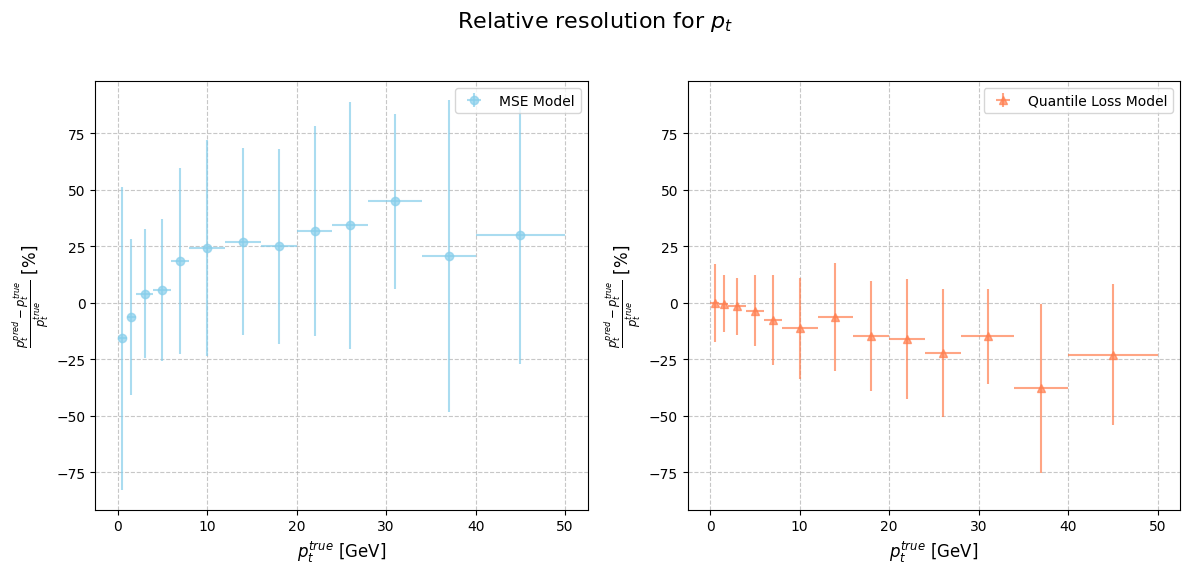

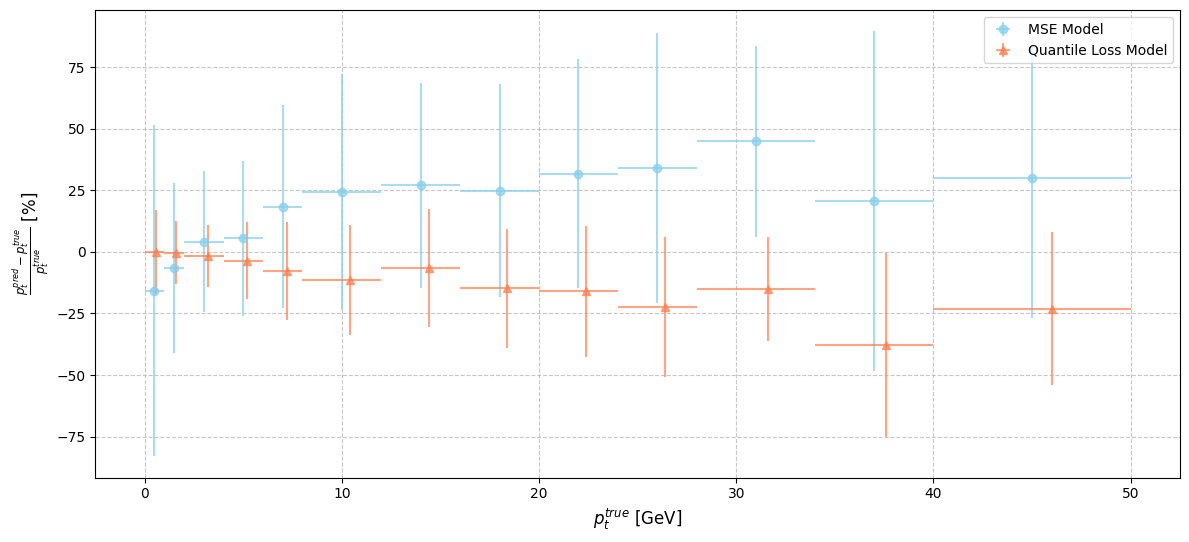

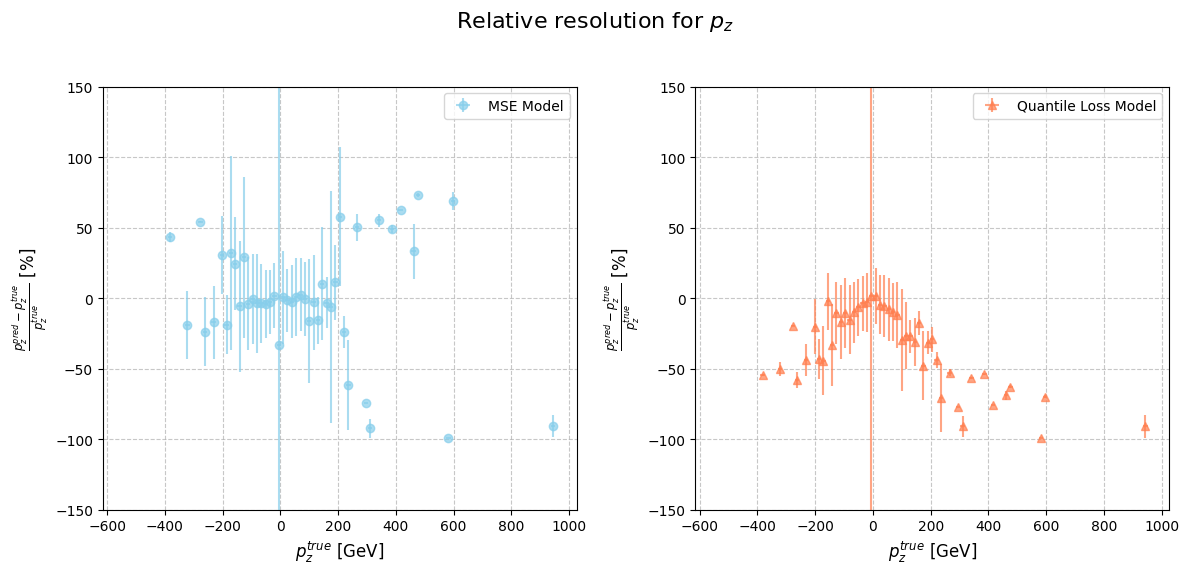

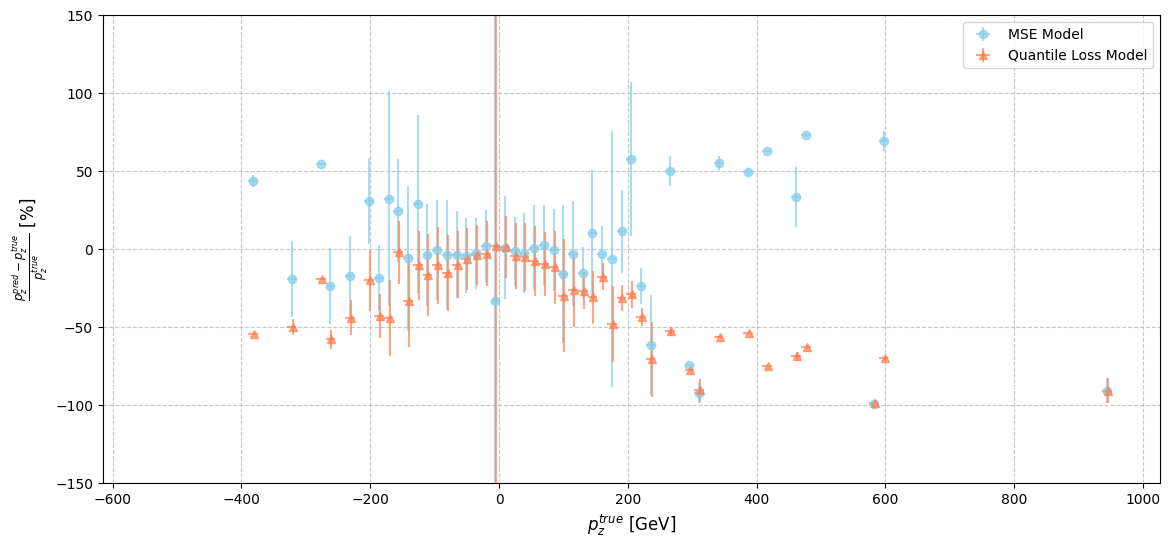

In [31]:
def plot_pi_rel_resolutions():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        relative_errors_mse_var = errors_mse_var / pi_true_list
        relative_errors_qloss_var = errors_qloss_var / pi_true_list

        # Make it percentage
        relative_errors_mse_var *= 100
        relative_errors_qloss_var *= 100

        title = f"Relative resolution for ${var}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = r"$\frac{" + f"{pred_label} - {true_label}".replace("$", "") + "}{" + f"{true_label}".replace("$", "") + "}$" + " [%]"
        filename = f"rel_resolution_{var}.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(min(pi_true_list), max(pi_true_list), 100)
        if var_index == 0:
            bins = np.logspace(
                np.log10(min(pi_true_list)), np.log10(max(pi_true_list)), 15
            )
            bins = np.logspace(
                np.log10(min(pi_true_list)), np.log10(50), 10
            )
            bins = np.array([0, 1, 2, 4, 6, 8, 12, 16, 20, 24, 28, 34, 40, 50])
            # print(bins)

        bin_counts_mse = []
        bin_counts_q_loss = []
        bin_std_mse = []
        bin_std_q_loss = []

        for bin_index in range(len(bins)):
            if bin_index == 0:
                lower_bound = -np.inf
                continue
            else:
                lower_bound = bins[bin_index - 1]
            upper_bound = bins[bin_index]

            sel = (lower_bound < pi_true_list) & (pi_true_list <= upper_bound)
            bin_counts_mse.append(np.mean(relative_errors_mse_var[sel]))
            bin_counts_q_loss.append(np.mean(relative_errors_qloss_var[sel]))
            bin_std_mse.append(np.std(relative_errors_mse_var[sel]))
            bin_std_q_loss.append(np.std(relative_errors_qloss_var[sel]))

        bin_centers = (bins[1:] + bins[:-1]) / 2

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.errorbar(
            bin_centers,
            bin_counts_mse,
            yerr=bin_std_mse,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        if var_index == 1:
            plt.ylim(-1.5*100, 1.5*100)

        # Qloss
        plt.subplot(1, 2, 2)
        plt.errorbar(
            bin_centers,
            bin_counts_q_loss,
            yerr=bin_std_q_loss,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            marker="^",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        if var_index == 1:
            plt.ylim(-1.5*100, 1.5*100)

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()

        # One figure
        filename = f"rel_resolution_{var}_one_plot.png"
        filename = output_dir / filename
        bin_sizes = bin_sizes = bins[1:] - bins[:-1]
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            bin_centers,
            bin_counts_mse,
            yerr=bin_std_mse,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        shift = bin_sizes * 0.1
        xerr_low = bin_sizes / 2 + shift
        xerr_high = bin_sizes / 2 - shift
        xerr_high[xerr_high < 0] = 0
        plt.errorbar(
            bin_centers + shift,
            bin_counts_q_loss,
            yerr=bin_std_q_loss,
            xerr=[xerr_low, xerr_high],
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            marker="^",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if var_index == 1:
            plt.ylim(-1.5*100, 1.5*100)
        # if var_index == 0:
        #     plt.xscale("log")
        #     # plt.yscale("log")
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_rel_resolutions()

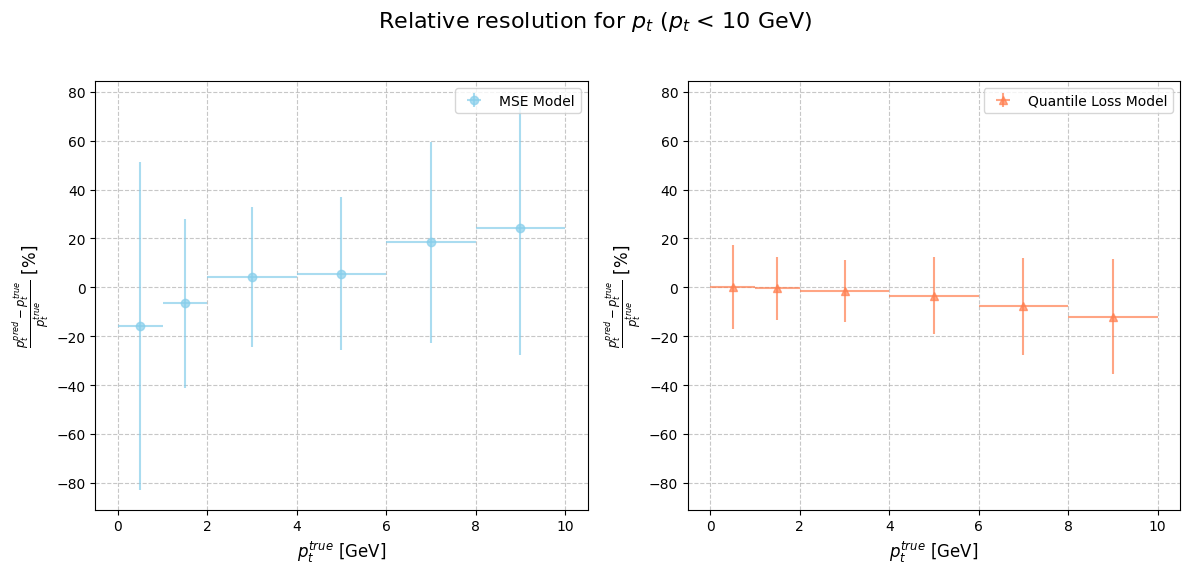

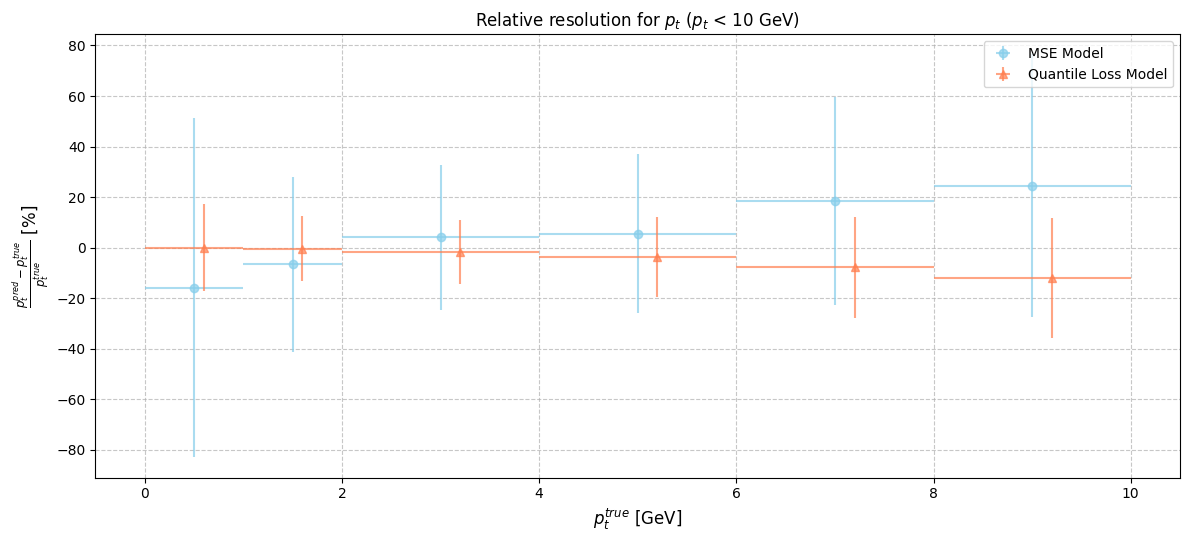

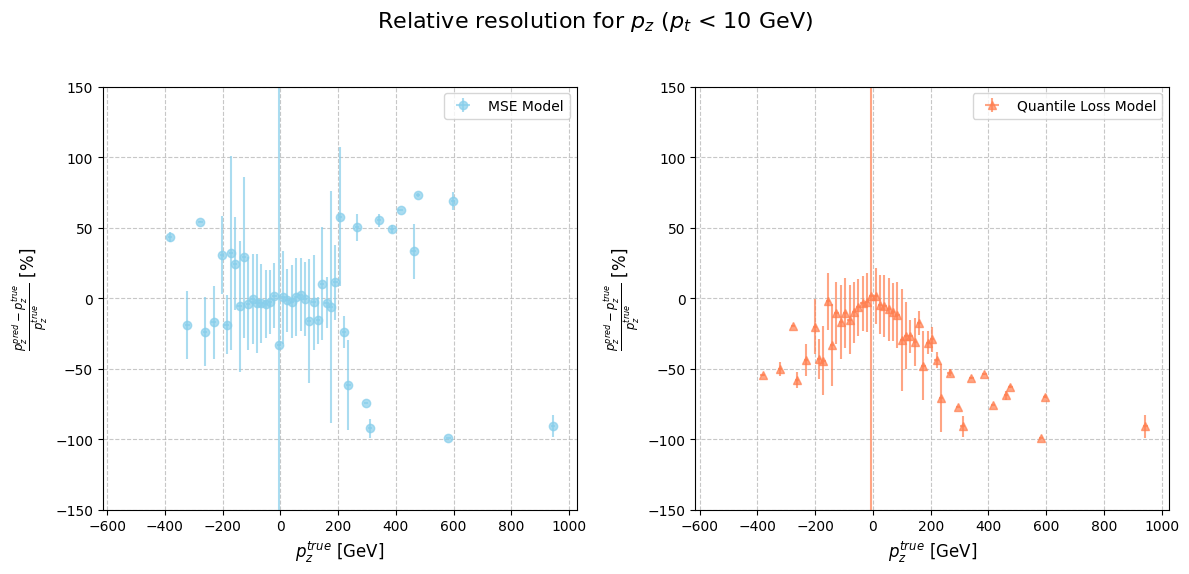

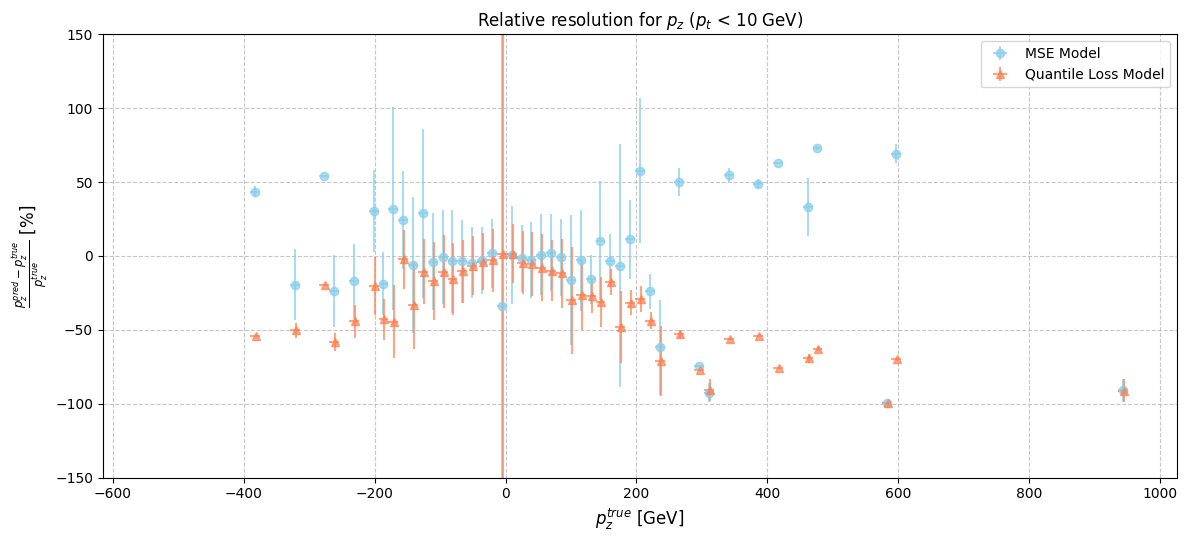

In [32]:
def plot_pi_rel_resolutions_low_pt():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        relative_errors_mse_var = errors_mse_var / pi_true_list
        relative_errors_qloss_var = errors_qloss_var / pi_true_list

        # Make it percentage
        relative_errors_mse_var *= 100
        relative_errors_qloss_var *= 100

        title = f"Relative resolution for ${var}$ ($p_t$ < 10 GeV)"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = r"$\frac{" + f"{pred_label} - {true_label}".replace("$", "") + "}{" + f"{true_label}".replace("$", "") + "}$" + " [%]"
        filename = f"rel_resolution_{var}_low_pt.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(min(pi_true_list), max(pi_true_list), 100)
        if var_index == 0:
            bins = np.logspace(
                np.log10(min(pi_true_list)), np.log10(max(pi_true_list)), 15
            )
            bins = np.logspace(
                np.log10(min(pi_true_list)), np.log10(50), 10
            )
            bins = np.array([0, 1, 2, 4, 6, 8, 10])
            # print(bins)

        bin_counts_mse = []
        bin_counts_q_loss = []
        bin_std_mse = []
        bin_std_q_loss = []

        for bin_index in range(len(bins)):
            if bin_index == 0:
                lower_bound = -np.inf
                continue
            else:
                lower_bound = bins[bin_index - 1]
            upper_bound = bins[bin_index]

            sel = (lower_bound < pi_true_list) & (pi_true_list <= upper_bound)
            bin_counts_mse.append(np.mean(relative_errors_mse_var[sel]))
            bin_counts_q_loss.append(np.mean(relative_errors_qloss_var[sel]))
            bin_std_mse.append(np.std(relative_errors_mse_var[sel]))
            bin_std_q_loss.append(np.std(relative_errors_qloss_var[sel]))

        bin_centers = (bins[1:] + bins[:-1]) / 2

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.errorbar(
            bin_centers,
            bin_counts_mse,
            yerr=bin_std_mse,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        if var_index == 1:
            plt.ylim(-1.5*100, 1.5*100)

        # Qloss
        plt.subplot(1, 2, 2)
        plt.errorbar(
            bin_centers,
            bin_counts_q_loss,
            yerr=bin_std_q_loss,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            marker="^",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        if var_index == 1:
            plt.ylim(-1.5*100, 1.5*100)

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()

        # One figure
        filename = f"rel_resolution_{var}_low_pt_one_plot.png"
        filename = output_dir / filename
        bin_sizes = bin_sizes = bins[1:] - bins[:-1]
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            bin_centers,
            bin_counts_mse,
            yerr=bin_std_mse,
            xerr=(bins[1:] - bins[:-1]) / 2,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        shift = bin_sizes * 0.1
        xerr_low = bin_sizes / 2 + shift
        xerr_high = bin_sizes / 2 - shift
        xerr_high[xerr_high < 0] = 0
        plt.errorbar(
            bin_centers + shift,
            bin_counts_q_loss,
            yerr=bin_std_q_loss,
            xerr=[xerr_low, xerr_high],
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            marker="^",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        plt.title(title)
        if var_index == 1:
            plt.ylim(-1.5*100, 1.5*100)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # if i == 0:
        #     plt.xscale("log")
        #     # plt.yscale("log")
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_rel_resolutions_low_pt()

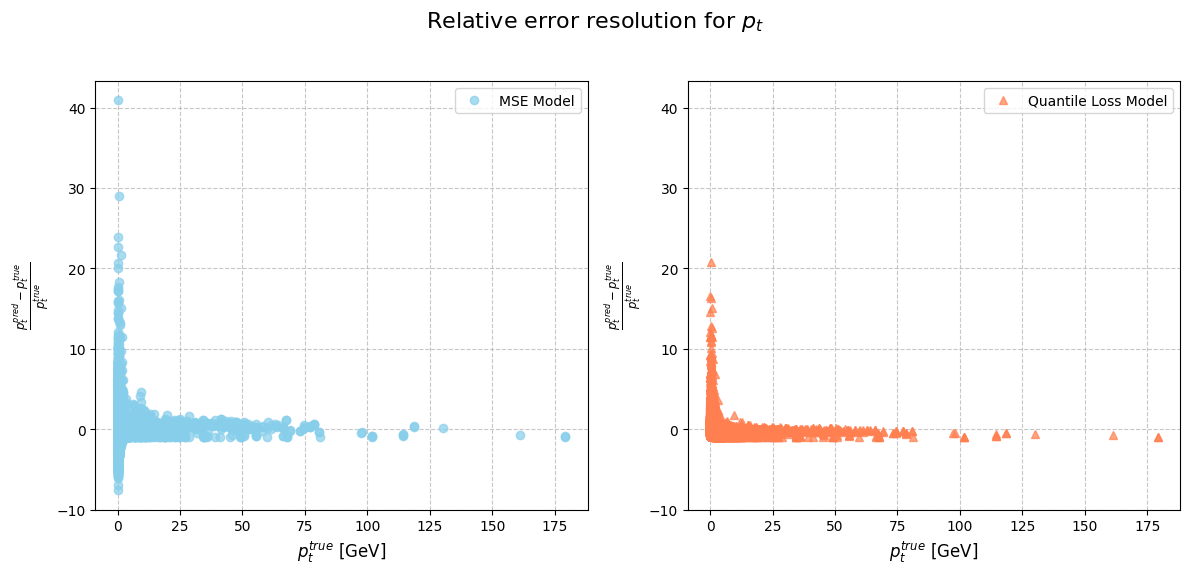

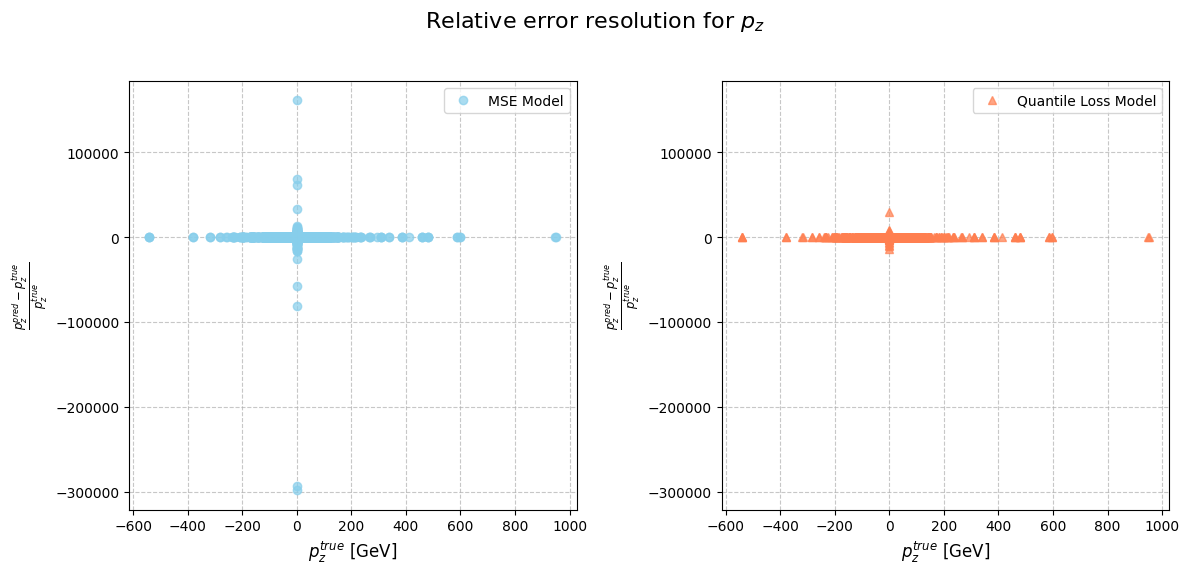

In [16]:
def plot_pi_rel_error_resolutions():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        relative_errors_mse_var = errors_mse_var / pi_true_list
        relative_errors_qloss_var = errors_qloss_var / pi_true_list
        
        title = f"Relative error resolution for ${var}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label + " [GeV]"
        ylabel = r"$\frac{" + f"{pred_label} - {true_label}".replace("$", "") + "}{" + f"{true_label}".replace("$", "") + "}$"
        filename = f"rel_error_resolution_{var}.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.plot(
            pi_true_list,
            relative_errors_mse_var,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            marker="o",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.plot(
            pi_true_list,
            relative_errors_qloss_var,
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            marker="^",
            linestyle="None",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()

plot_pi_rel_error_resolutions()

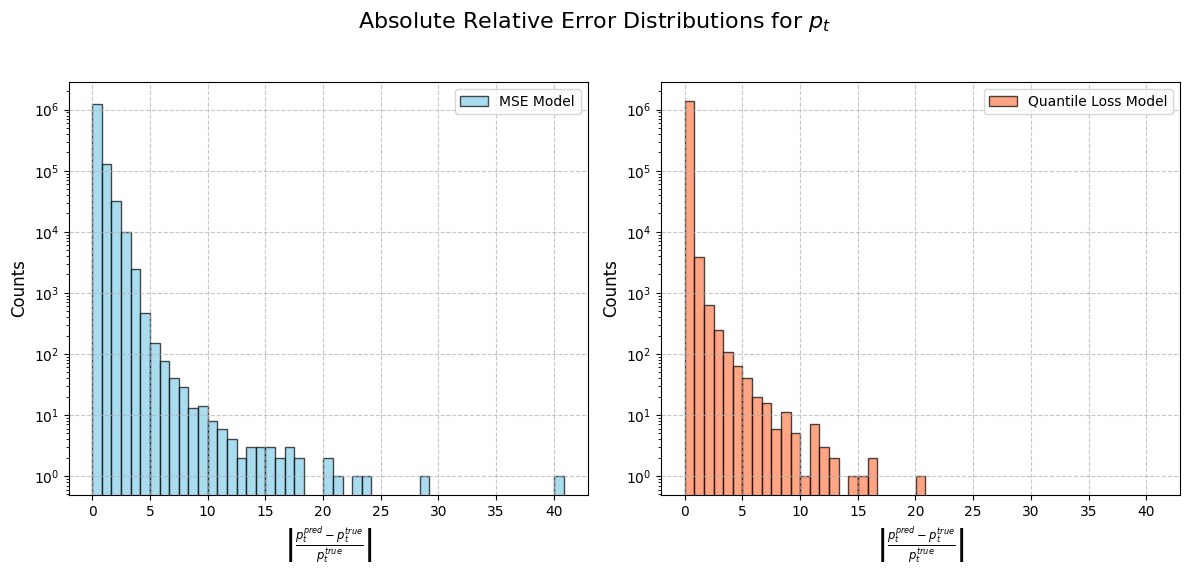

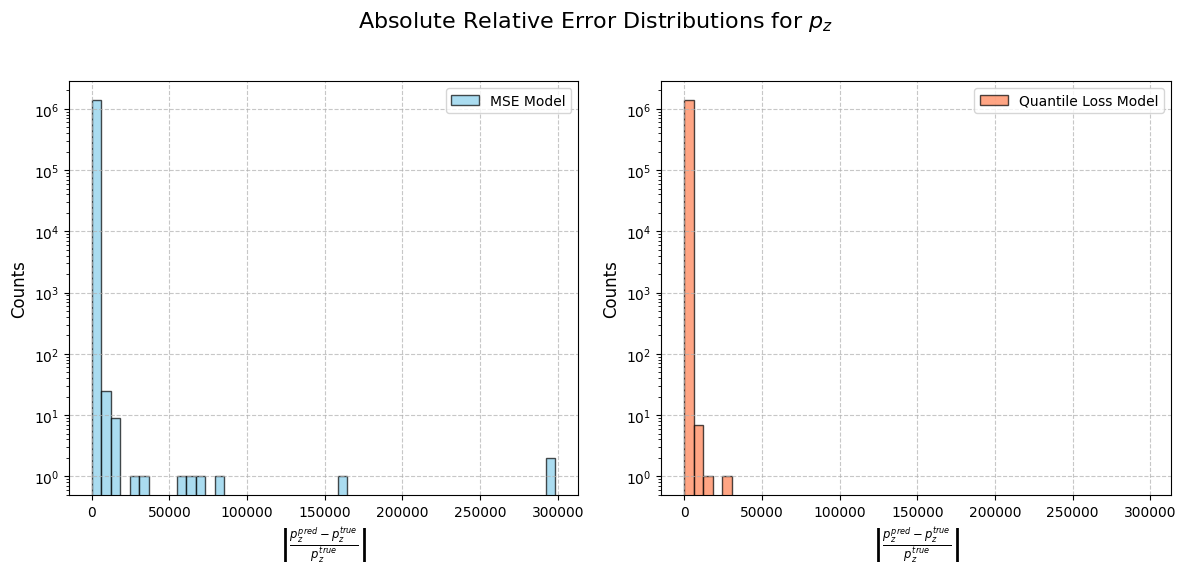

In [19]:
def plot_pi_absolute_relative_error_distributions():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        relative_errors_mse_var = errors_mse_var / pi_true_list
        relative_errors_qloss_var = errors_qloss_var / pi_true_list

        abs_relative_errors_mse_var = np.abs(relative_errors_mse_var)
        abs_relative_errors_qloss_var = np.abs(relative_errors_qloss_var)
        
        title = f"Absolute Relative Error Distributions for ${var}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = f"$\\left|\\frac{{ {pred_label.replace('$', '')} - {true_label.replace('$', '')} }}{{ {true_label.replace('$', '')} }}\\right|$"
        ylabel = "Counts"
        filename = f"absolute_relative_error_distributions_{var}.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(
            0,
            max(
                max(abs_relative_errors_mse_var),
                max(abs_relative_errors_qloss_var),
            ),
            50,
        )

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.hist(
            abs_relative_errors_mse_var,
            bins=bins,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.hist(
            abs_relative_errors_qloss_var,
            bins=bins,
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_absolute_relative_error_distributions()

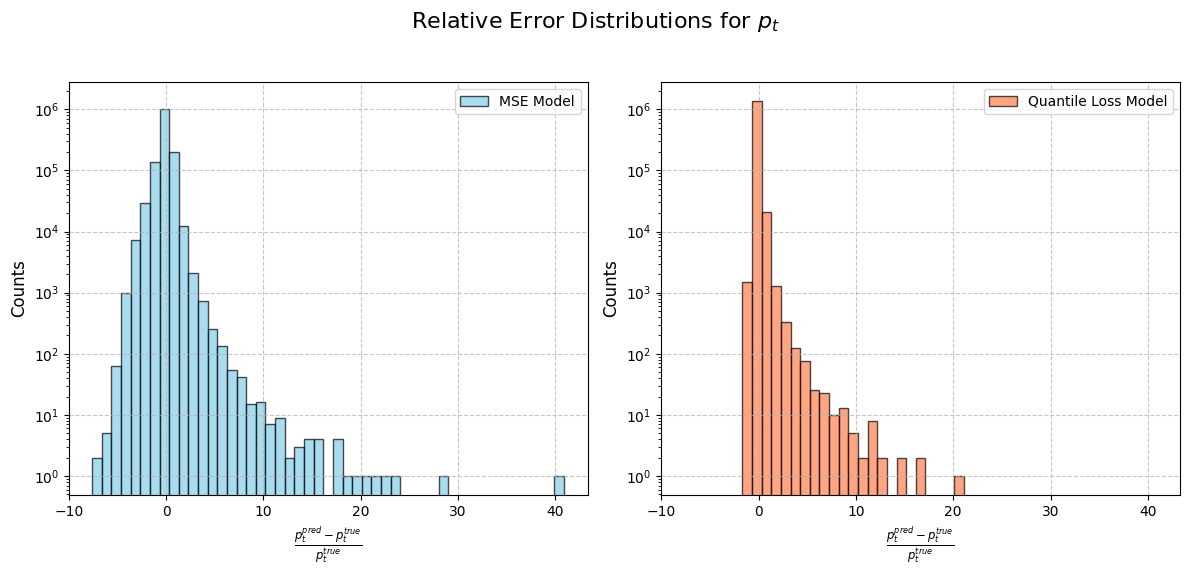

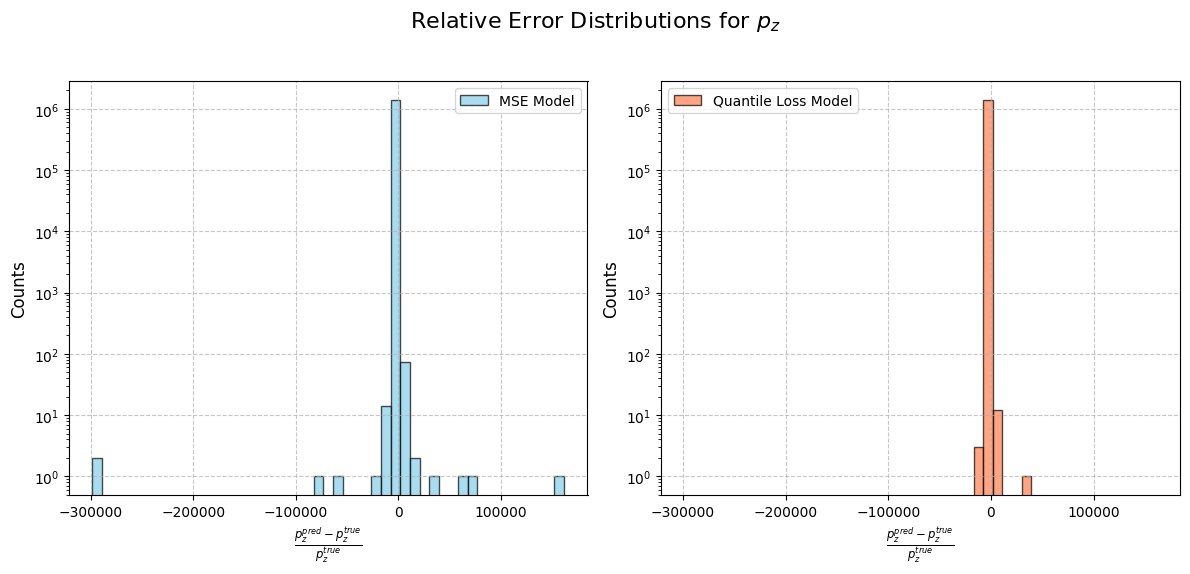

In [20]:
def plot_pi_relative_error_distributions():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        relative_errors_mse_var = errors_mse_var / pi_true_list
        relative_errors_qloss_var = errors_qloss_var / pi_true_list
        
        title = f"Relative Error Distributions for ${var}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = f"$\\frac{{ {pred_label.replace('$', '')} - {true_label.replace('$', '')} }}{{ {true_label.replace('$', '')} }}$"
        ylabel = "Counts"
        filename = f"relative_error_distributions_{var}.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(
            min(min(relative_errors_mse_var), min(relative_errors_qloss_var)),
            max(
                max(relative_errors_mse_var),
                max(relative_errors_qloss_var),
            ),
            50,
        )

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.hist(
            relative_errors_mse_var,
            bins=bins,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.hist(
            relative_errors_qloss_var,
            bins=bins,
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_relative_error_distributions()

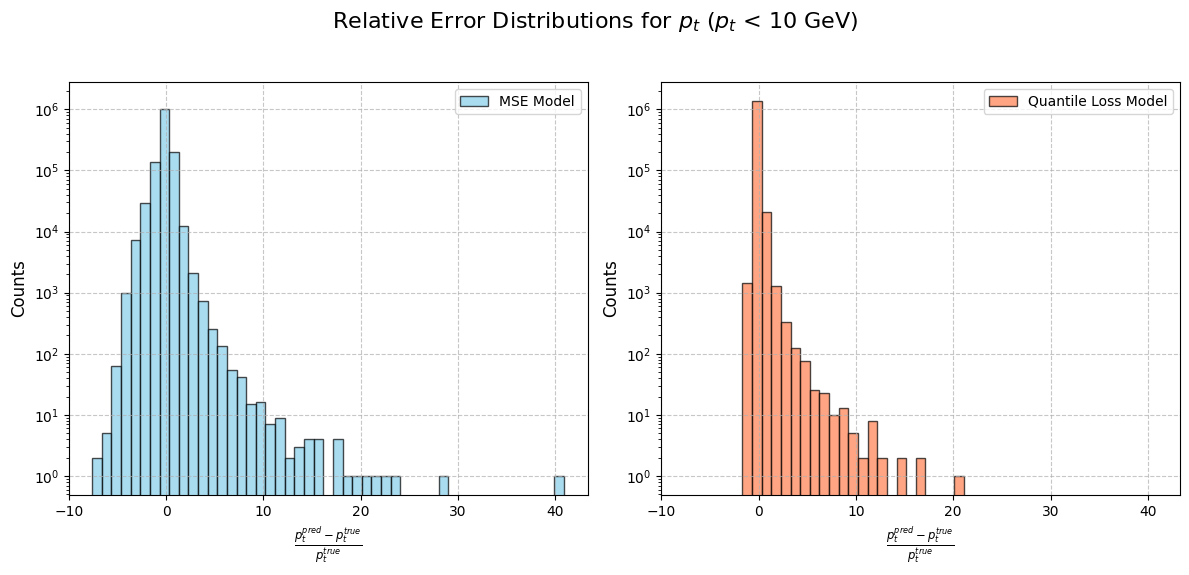

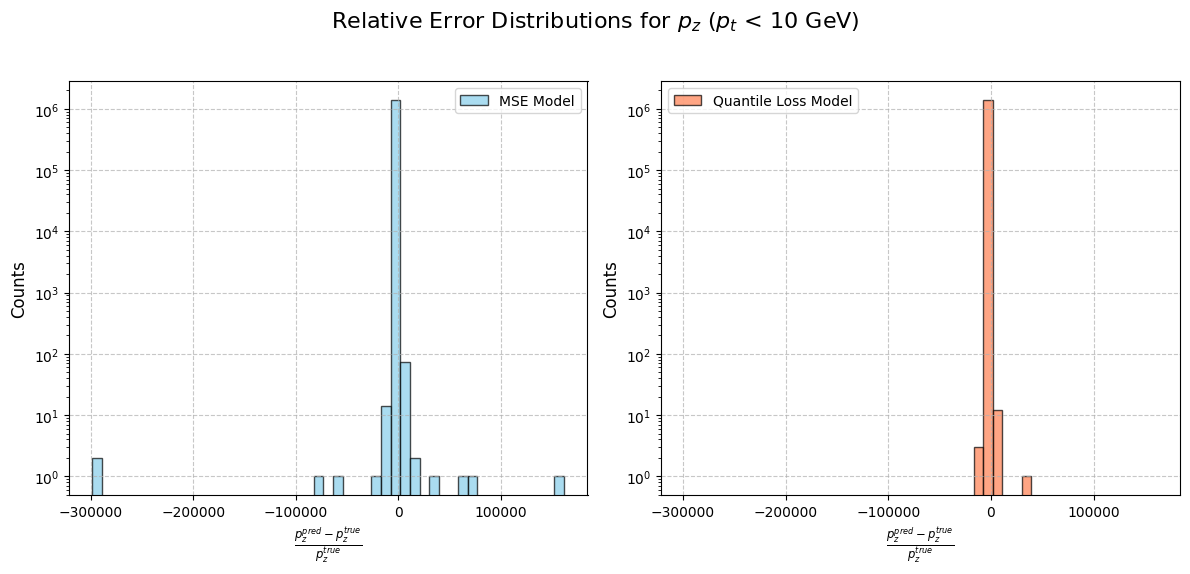

In [21]:
def plot_pi_relative_error_distributions_low_pt():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]

        errors_mse_var = pi_pred_mse_list - pi_true_list
        errors_qloss_var = pi_pred_qloss_list - pi_true_list

        relative_errors_mse_var = errors_mse_var / pi_true_list
        relative_errors_qloss_var = errors_qloss_var / pi_true_list

        pt_true = np.array(p_true_list)[:, 0]
        mask = pt_true < 10
        relative_errors_mse_var = relative_errors_mse_var[mask]
        relative_errors_qloss_var = relative_errors_qloss_var[mask]
        
        title = f"Relative Error Distributions for ${var}$ ($p_t$ < 10 GeV)"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = f"$\\frac{{ {pred_label.replace('$', '')} - {true_label.replace('$', '')} }}{{ {true_label.replace('$', '')} }}$"
        ylabel = "Counts"
        filename = f"relative_error_distributions_{var}_low_pt.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(
            min(min(relative_errors_mse_var), min(relative_errors_qloss_var)),
            max(
                max(relative_errors_mse_var),
                max(relative_errors_qloss_var),
            ),
            50,
        )

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.hist(
            relative_errors_mse_var,
            bins=bins,
            alpha=0.7,
            label="MSE Model",
            color="skyblue",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.hist(
            relative_errors_qloss_var,
            bins=bins,
            alpha=0.7,
            label="Quantile Loss Model",
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi_relative_error_distributions_low_pt()

In [ ]:
bad_tracks_q[i][0]

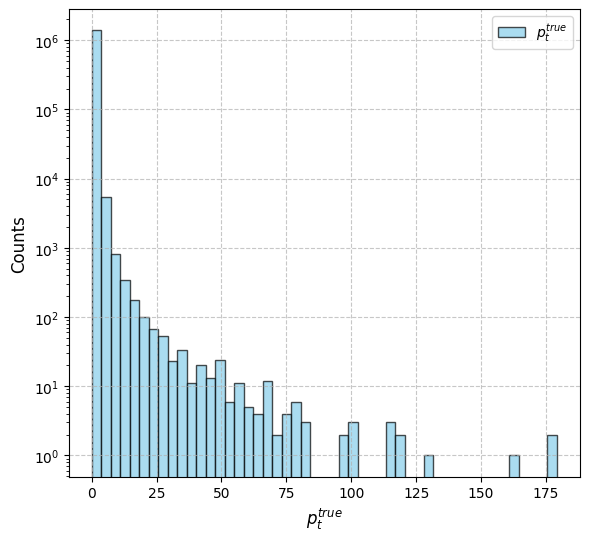

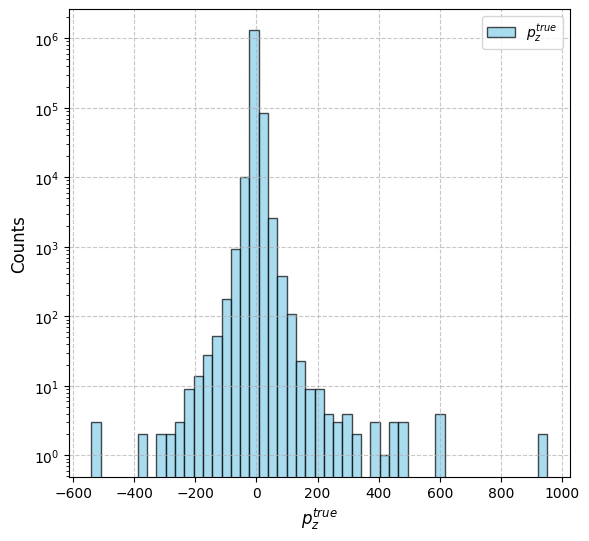

In [22]:
def plot_alone_pi():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        title = f"${var}^{{true}}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = true_label
        filename = f"{var}_true.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(6, 6))

        bins = np.linspace(
            min(pi_true_list),
                max(pi_true_list),
            50,
        )

        plt.hist(
            pi_true_list,
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        # plt.title(title)
        plt.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_alone_pi()

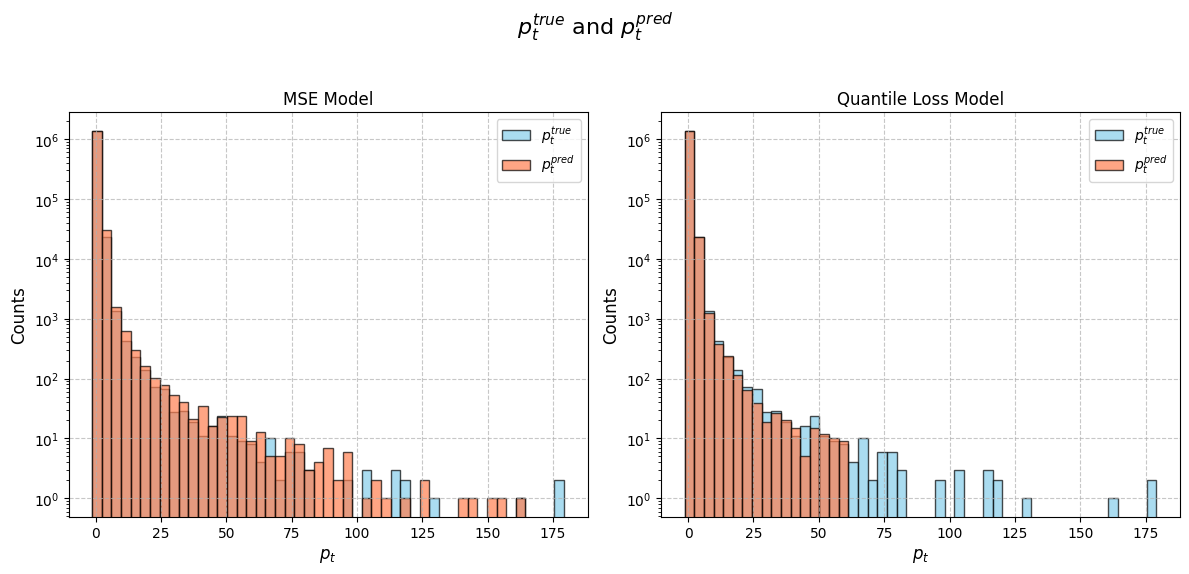

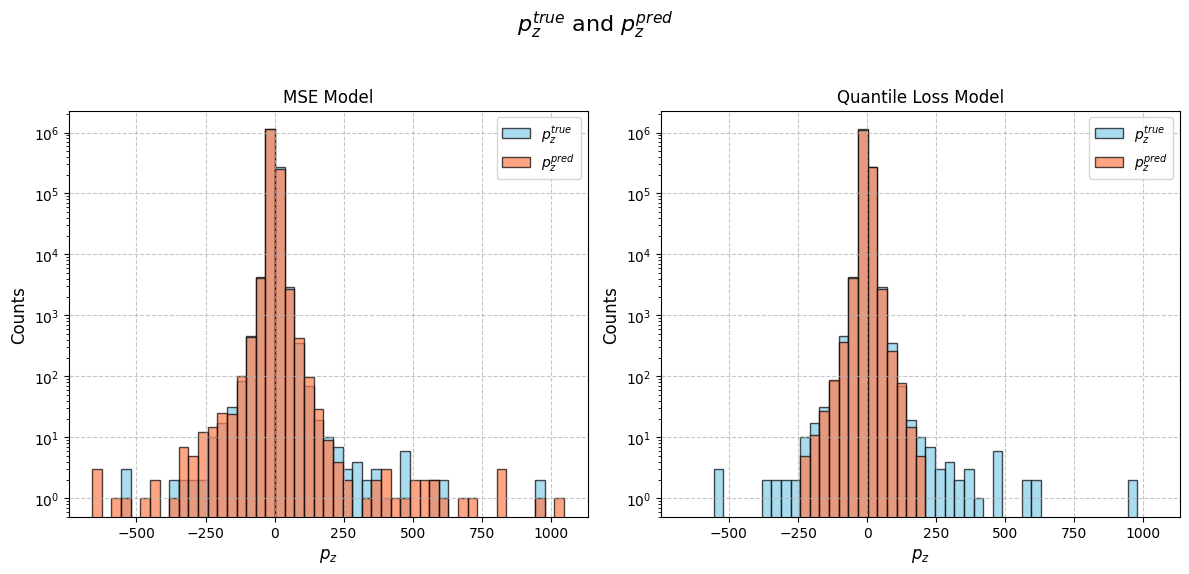

In [23]:
def plot_pi():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]
        
        title = f"${var}^{{true}}$ and ${var}^{{pred}}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = f"${var}$"
        filename = f"{var}_true_and_{var}_pred.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(
            min(min(pi_true_list), min(pi_pred_mse_list), min(pi_pred_qloss_list)),
            max(
                max(pi_true_list),
                max(pi_pred_mse_list),
                max(pi_pred_qloss_list),
            ),
            50,
        )

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.hist(
            pi_true_list,
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.hist(
            pi_pred_mse_list,
            bins=bins,
            alpha=0.7,
            label=pred_label,
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title("MSE Model")
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.hist(
            pi_true_list,
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.hist(
            pi_pred_qloss_list,
            bins=bins,
            alpha=0.7,
            label=pred_label,
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title("Quantile Loss Model")
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_pi()

In [ ]:
def plot_pi_cdf():
    """Plot CDF of p_t and p_z"""
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]
        
        title = f"CDF of ${var}^{{true}}$ and ${var}^{{pred}}$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        xlabel = f"CDF of ${var}$"
        filename = f"{var}_true_and_{var}_pred_cdf.png"
        filename = output_dir / filename

        # Import necessary CDF function
        from scipy.stats import norm

        pi_true_list_cdf = np.sort(pi_true_list)
        pi_pred_mse_list_cdf = np.sort(pi_pred_mse_list)
        pi_pred_qloss_list_cdf = np.sort(pi_pred_qloss_list)

        pi_true_list_cdf_ = np.linspace(0, 1, len(pi_true_list_cdf))
        pi_pred_mse_list_cdf_ = np.linspace(0, 1, len(pi_pred_mse_list_cdf))
        pi_pred_qloss_list_cdf_ = np.linspace(0, 1, len(pi_pred_qloss_list_cdf))

        pi_true_list_cdf = norm.ppf(pi_true_list_cdf_)
        pi_pred_mse_list_cdf = norm.ppf(pi_pred_mse_list_cdf_)
        pi_pred_qloss_list_cdf = norm.ppf(pi_pred_qloss_list_cdf_)

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(
            min(min(pi_true_list), min(pi_pred_mse_list), min(pi_pred_qloss_list)),
            max(
                max(pi_true_list),
                max(pi_pred_mse_list),
                max(pi_pred_qloss_list),
            ),
            50,
        )

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.hist(
            pi_true_list,
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.hist(
            pi_pred_mse_list,
            bins=bins,
            alpha=0.7,
            label=pred_label,
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title("MSE Model")
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.hist(
            pi_true_list,
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.hist(
            pi_pred_qloss_list,
            bins=bins,
            alpha=0.7,
            label=pred_label,
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title("Quantile Loss Model")
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


# plot_pi_cdf()

/tmp/ipykernel_14739/3716710468.py:22: RuntimeWarning: invalid value encountered in log10
  max(np.log10(pi_pred_mse_list)),
/tmp/ipykernel_14739/3716710468.py:39: RuntimeWarning: invalid value encountered in log10
  np.log10(pi_pred_mse_list),


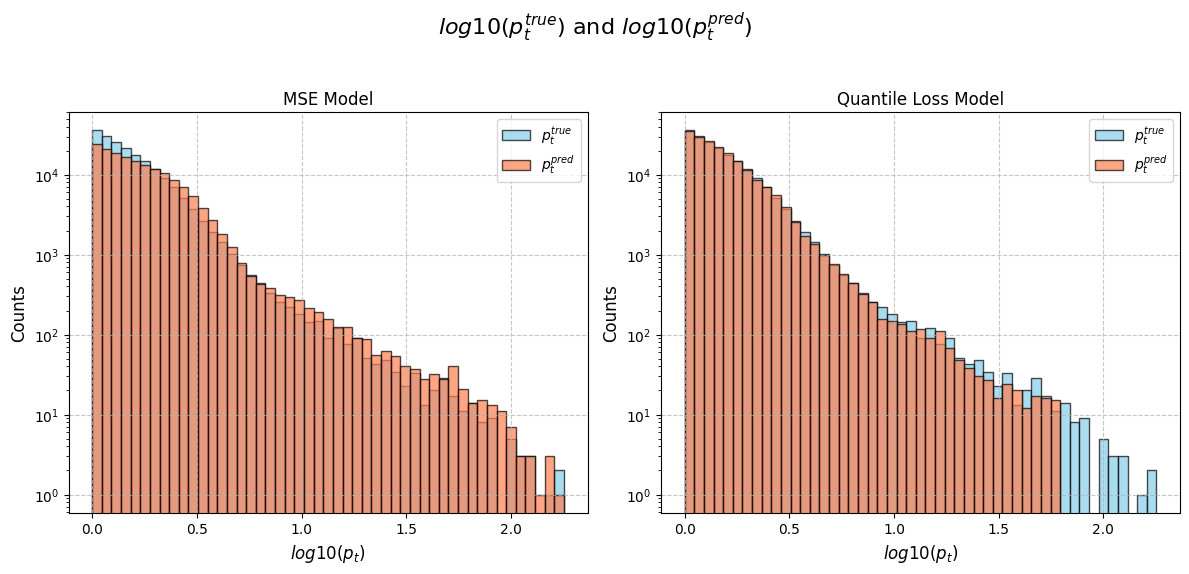

/tmp/ipykernel_14739/3716710468.py:21: RuntimeWarning: invalid value encountered in log10
  max(np.log10(pi_true_list)),
/tmp/ipykernel_14739/3716710468.py:23: RuntimeWarning: invalid value encountered in log10
  max(np.log10(pi_pred_qloss_list)),
/tmp/ipykernel_14739/3716710468.py:31: RuntimeWarning: invalid value encountered in log10
  np.log10(pi_true_list),
/tmp/ipykernel_14739/3716710468.py:56: RuntimeWarning: invalid value encountered in log10
  np.log10(pi_true_list),
/tmp/ipykernel_14739/3716710468.py:64: RuntimeWarning: invalid value encountered in log10
  np.log10(pi_pred_qloss_list),


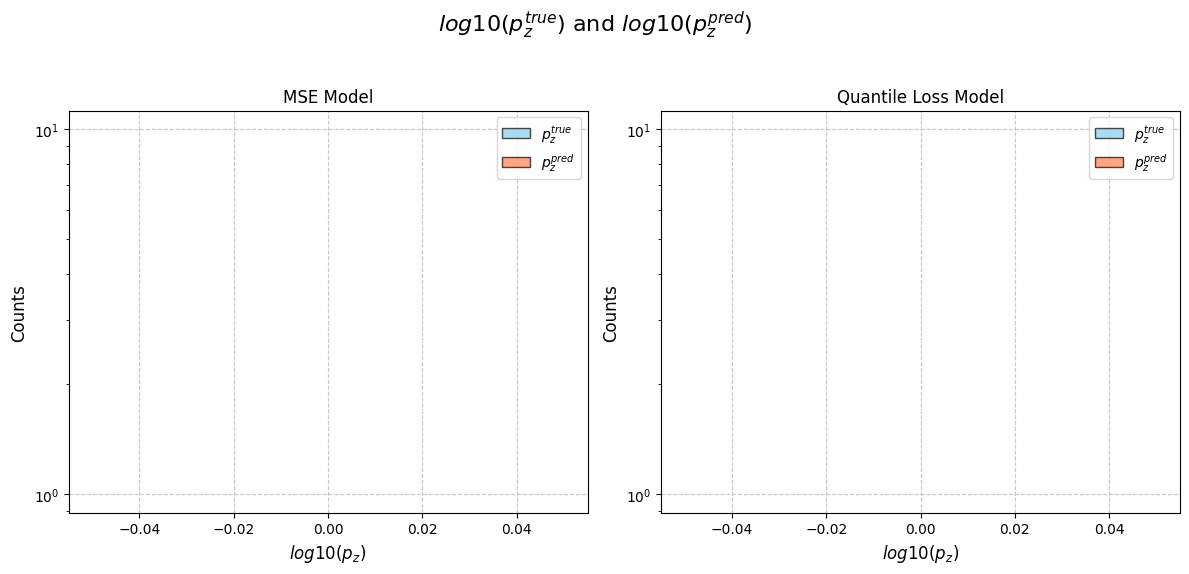

In [24]:
def plot_log10_pi():
    for var_index, var in enumerate(target_labels):
        pi_true_list = np.array(p_true_list)[:, var_index]
        pi_pred_mse_list = np.array(p_pred_mse_list)[:, var_index]
        pi_pred_qloss_list = np.array(p_pred_qloss_list)[:, var_index]
        
        title = f"$log10({var}^{{true}})$ and $log10({var}^{{pred}})$"
        xlabel = f"$log10({var})$"
        true_label = f"${var}^{{true}}$"
        pred_label = f"${var}^{{pred}}$"
        filename = f"log10_{var}_true_and_log10_{var}_pred.png"
        filename = output_dir / filename

        # Plot pt_true and pt_pred
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        bins = np.linspace(
            0,
            max(
                max(np.log10(pi_true_list)),
                max(np.log10(pi_pred_mse_list)),
                max(np.log10(pi_pred_qloss_list)),
            ),
            50,
        )

        # MSE Model
        plt.subplot(1, 2, 1)
        plt.hist(
            np.log10(pi_true_list),
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.hist(
            np.log10(pi_pred_mse_list),
            bins=bins,
            alpha=0.7,
            label=pred_label,
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title("MSE Model")
        plt.legend()

        # Qloss
        plt.subplot(1, 2, 2)
        plt.hist(
            np.log10(pi_true_list),
            bins=bins,
            alpha=0.7,
            label=true_label,
            color="skyblue",
            edgecolor="black",
        )
        plt.hist(
            np.log10(pi_pred_qloss_list),
            bins=bins,
            alpha=0.7,
            label=pred_label,
            color="coral",
            edgecolor="black",
        )
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.title("Quantile Loss Model")
        plt.legend()

        sync_plot_limits()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, format="png")
        plt.show()


plot_log10_pi()

In [25]:

import torch.nn.functional as F
from sklearn.utils import resample
from scipy.stats import bootstrap

def evaluate_models():
    # Initialize lists to store the MAE values
    m_transf_mae_pt = []
    m_transf_mae_pz = []
    q_transf_mae_pt = []
    q_transf_mae_pz = []

    pt_conf_mae_list = []
    batch_limit = 10
    epochs = 1
    for epoch in tqdm(range(epochs)):
        with torch.no_grad():
            for i, (input, _, target) in enumerate(tqdm(tl)):
                if i >= batch_limit:
                    break
                # Transformer MSE
                pred1 = transf_mse_model(input)
                pt_mae1 = F.l1_loss(pred1[:, 0], target[:, 0])
                pz_mae1 = F.l1_loss(pred1[:, 1], target[:, 1])

                m_transf_mae_pt.append(pt_mae1.item())
                m_transf_mae_pz.append(pz_mae1.item())

                # Transformer Qloss
                pred2 = qloss_transf_tt_model(input)
                pt_mae2 = F.l1_loss(pred2[:, 0], target[:, 0])
                pz_mae2 = F.l1_loss(pred2[:, 1], target[:, 1])

                q_transf_mae_pt.append(pt_mae2.item())
                q_transf_mae_pz.append(pz_mae2.item())

                # conformal fitt squares
                # pt_conf_mae = conformal_mae(input, target)
                # pt_conf_mae_list.append(pt_conf_mae.item())

    # Convert lists to numpy arrays
    m_transf_mae_pt = np.array(m_transf_mae_pt)
    q_transf_mae_pt = np.array(q_transf_mae_pt)
    m_transf_mae_pz = np.array(m_transf_mae_pz)
    q_transf_mae_pz = np.array(q_transf_mae_pz)
    # pt_conf_mae_list = np.array(pt_conf_mae_list)

    def calculate_ci(data, confidence=0.95, n_resamples=1000):
        res = bootstrap(
            (data,),
            np.mean,
            confidence_level=confidence,
            n_resamples=n_resamples,
            method="percentile",
            random_state=42,
        )
        mean = np.mean(data)
        ci_lower = res.confidence_interval.low
        ci_upper = res.confidence_interval.high
        delta = (ci_upper - mean) / 2
        return mean, delta

    # confidence intervals
    transf_mse_pt_mean, transf_mse_pt_delta = calculate_ci(m_transf_mae_pt)
    transf_q_pt_mean, transf_q_pt_delta = calculate_ci(q_transf_mae_pt)
    transf_mse_pz_mean, transf_mse_pz_delta = calculate_ci(m_transf_mae_pz)
    transf_q_pz_mean, transf_q_pz_delta = calculate_ci(q_transf_mae_pz)
    # pt_conf_mean, pt_conf_delta = calculate_ci(pt_conf_mae_list)

    print(
        f"Transformer MSE PT MAE: {transf_mse_pt_mean:.4f} ± {transf_mse_pt_delta:.4f}"
    )
    print(f"Transformer Qloss PT MAE: {transf_q_pt_mean:.4f} ± {transf_q_pt_delta:.4f}")
    print(
        f"Transformer MSE PZ MAE: {transf_mse_pz_mean:.4f} ± {transf_mse_pz_delta:.4f}"
    )
    print(f"Transformer Qloss PZ MAE: {transf_q_pz_mean:.4f} ± {transf_q_pz_delta:.4f}")
    # print(f"Conformal MAE: {pt_conf_mean:.4f} ± {pt_conf_delta:.4f}")

    # Save the results to a file
    results = {}
    results["p_t"] = {"mse": (transf_mse_pt_mean, transf_mse_pt_delta), "qloss": (transf_q_pt_mean, transf_q_pt_delta)}
    results["p_z"] = {"mse": (transf_mse_pz_mean, transf_mse_pz_delta), "qloss": (transf_q_pz_mean, transf_q_pz_delta)}
    # results["conformal"] = (pt_conf_mean, pt_conf_delta)

    with open(output_dir / "mae_results.json", "w") as f:
        json.dump(results, f)

evaluate_models()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/43884 [00:00<?, ?it/s]

Transformer MSE PT MAE: 0.6096 ± 0.2413
Transformer Qloss PT MAE: 0.1586 ± 0.0756
Transformer MSE PZ MAE: 1.1091 ± 0.2778
Transformer Qloss PZ MAE: 0.5821 ± 0.2140


Transformer MSE PT MAE: 0.4409 ± 0.1944
Transformer Qloss PT MAE: 0.1949 ± 0.0778
Transformer MSE PZ MAE: 1.3537 ± 0.5189
Transformer Qloss PZ MAE: 0.7749 ± 0.2834

Transformer MSE PT MAE: 0.5884 ± 0.2166
Transformer Qloss PT MAE: 0.1474 ± 0.0739
Transformer MSE PZ MAE: 1.3716 ± 0.3525
Transformer Qloss PZ MAE: 0.6085 ± 0.1636

In [26]:
from tbparse import SummaryReader

def plot_tensorboard(log_dir):
    reader = SummaryReader(log_dir, extra_columns={"dir_name"}, pivot=False)
    # reader = SummaryReader(log_dir)
    df = reader.scalars
    print(df)

    df["unique_tag"] = df["dir_name"] + "/" + df["tag"]

    # Get the unique tags
    unique_tags = df["tag"].unique()

    print(unique_tags)

    # Extract values for each tag
    unique_tags_dfs = {}
    for tag in unique_tags:
        unique_tags_dfs[tag] = df[df["tag"] == tag].reset_index(drop=True)

        print(unique_tags_dfs[tag])

    for tag in unique_tags:
        # if not "loss" in unique_tags_dfs[tag]
        plt.figure()
        for dir_name in unique_tags_dfs[tag]["dir_name"].unique():
            dir_name_sel = unique_tags_dfs[tag]["dir_name"] == dir_name

            dir_df = unique_tags_dfs[tag][dir_name_sel]
            # Group by step and take the mean and std
            dir_df = dir_df.groupby("step").agg({"value": ["mean", "std"]})
            # dir_df.columns = dir_df.columns.droplevel(0)
            dir_df.reset_index(inplace=True)
            plt.errorbar(
                x=dir_df["step"],
                y=dir_df["value"]["mean"],
                label=dir_name,
                alpha=0.7,
                yerr=dir_df["value"]["std"],
            )
        # sns.lineplot(data=unique_tags_dfs[tag], x="step", y="value")
        # plt.title(tag)
        plt.xlabel("Step")
        plt.ylabel(tag.capitalize())
        plt.legend()
        plt.grid(True)
        plt.savefig(output_dir / (tag + "_" + log_dir.split('/')[-1] + ".png"), format="png")

    tag = "loss"
    plt.figure()
    for dir_name in unique_tags_dfs[tag]["dir_name"].unique():
        dir_name_sel = unique_tags_dfs[tag]["dir_name"] == dir_name

        dir_df = unique_tags_dfs[tag][dir_name_sel]
        # Group by step and take the mean and std
        dir_df = dir_df.groupby("step").agg({"value": ["mean", "std"]})
        # dir_df.columns = dir_df.columns.droplevel(0)
        dir_df.reset_index(inplace=True)
        plt.errorbar(
            x=dir_df["step"],
            y=dir_df["value"]["mean"],
            label=dir_name,
            alpha=0.7,
            yerr=dir_df["value"]["std"],
        )
    # sns.lineplot(data=unique_tags_dfs[tag], x="step", y="value")
    # plt.title(tag)
    plt.xlabel("Step")
    plt.ylabel(tag.capitalize())
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.savefig(output_dir / ("loss_log_log_" + log_dir.split('/')[-1] + ".png"), format="png")
    plt.show()


2025-01-29 15:04:21.607328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


            step       tag     value  dir_name
0              0  lr-AdamW  0.000000          
1              1  lr-AdamW  0.000005          
2              2  lr-AdamW  0.000010          
3              3  lr-AdamW  0.000015          
4              4  lr-AdamW  0.000020          
...          ...       ...       ...       ...
2331897  1096900      loss  0.102231  loss_val
2331898  1096900      loss  0.111466  loss_val
2331899  1096900      loss  0.086959  loss_val
2331900  1096900      loss  0.115031  loss_val
2331901  1096900      loss  0.082680  loss_val

[2331902 rows x 4 columns]
['lr-AdamW' 'loss']
            step       tag         value dir_name unique_tag
0              0  lr-AdamW  0.000000e+00           /lr-AdamW
1              1  lr-AdamW  5.000000e-06           /lr-AdamW
2              2  lr-AdamW  1.000000e-05           /lr-AdamW
3              3  lr-AdamW  1.500000e-05           /lr-AdamW
4              4  lr-AdamW  2.000000e-05           /lr-AdamW
...          ...      

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  mi

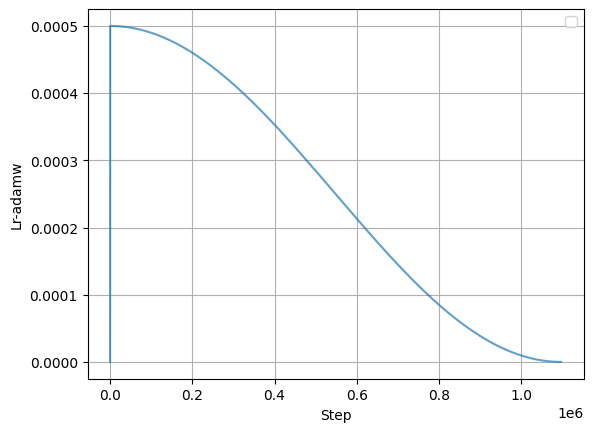

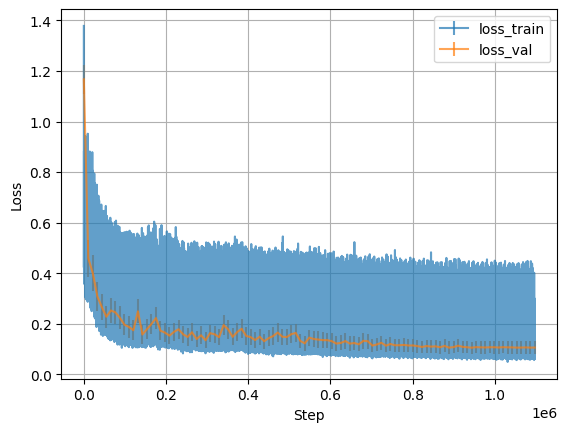

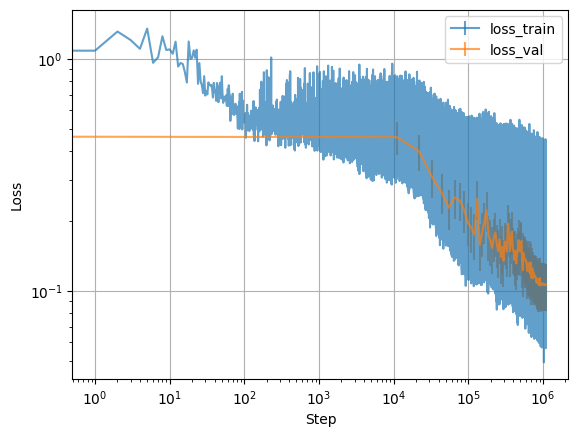

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# log_dir = "./Data/TrackML/version_115/loss_train"
log_dir = "./Data/TrackML/version_114"

plot_tensorboard(log_dir)


            step       tag     value  dir_name
0              0  lr-AdamW  0.000000          
1              1  lr-AdamW  0.000005          
2              2  lr-AdamW  0.000010          
3              3  lr-AdamW  0.000015          
4              4  lr-AdamW  0.000020          
...          ...       ...       ...       ...
2331897  1096900      loss  1.308651  loss_val
2331898  1096900      loss  2.078721  loss_val
2331899  1096900      loss  1.146659  loss_val
2331900  1096900      loss  1.145910  loss_val
2331901  1096900      loss  0.560511  loss_val

[2331902 rows x 4 columns]
['lr-AdamW' 'loss']
            step       tag         value dir_name unique_tag
0              0  lr-AdamW  0.000000e+00           /lr-AdamW
1              1  lr-AdamW  5.000000e-06           /lr-AdamW
2              2  lr-AdamW  1.000000e-05           /lr-AdamW
3              3  lr-AdamW  1.500000e-05           /lr-AdamW
4              4  lr-AdamW  2.000000e-05           /lr-AdamW
...          ...      

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  mi

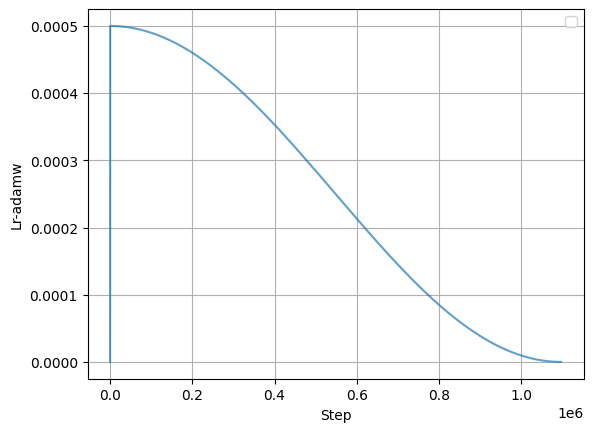

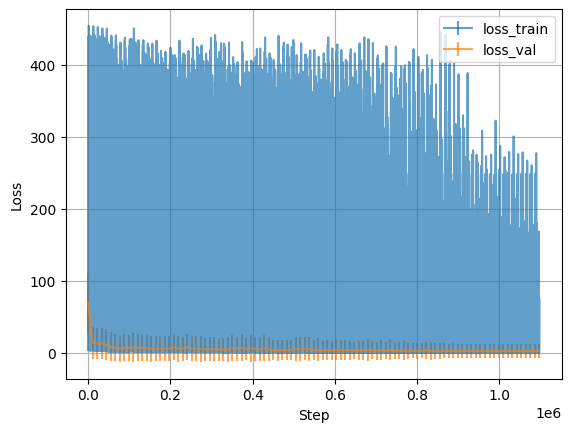

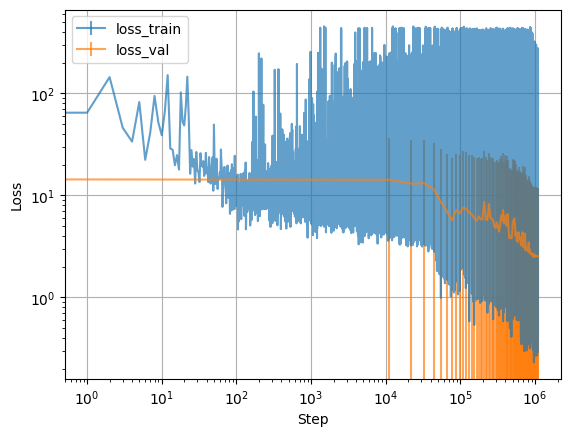

In [28]:
log_dir = "./Data/TrackML/version_115"
plot_tensorboard(log_dir)